In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style('white')
sns.set_context('talk')

In [531]:
def featurewise_outlier_replacer(X, q=(0.01, 0.99)):
    if "DataFrame" in str(type(X)):
        X = X.values
    Xnew = np.zeros((X.shape[0], X.shape[1]))
    for jdx in range(0, X.shape[1]):
        x = X[:, jdx]
        Xnew[:, jdx] = _featurewise_outlier_replacer(x, q)
    return Xnew

def _featurewise_outlier_replacer(x, q=(0.01, 0.99), how='quantile'):
    if how == 'quantile':
        # improvement..instead of blunt replacement with fixed number use sampler
        lv, rv = np.quantile(x, q[0]), np.quantile(x, q[1])
        t = x.copy()
        t[t > rv] = rv
        t[t < lv] = lv
        return t
    
def estimator_fun(X, weights, intercept, sigma):
    return np.dot(X, weights)+intercept+np.random.randn(X.shape[0])*sigma

Main concepts:
* Bayes rule and probability
* Prior and Posterior distributions
* Sampling and Monte Carlo simulationsi
* Stochastic processes
* Bayesian Inference
* Bayesian Modeling

Probability: *percentage of credibility or plausibility of any given value-range if you have to divide the credibility over minus/plus infinity*

Bayes rule: $$p(\mathbf{w}\vert D) = \frac{p(D\vert \mathbf{w})\, p(\mathbf{w})}{p(D)} $$
=>

Probability that our dependent variables are $\mathbf{w}$ given some distribution of our independent variables $D$ **=** 
* **likelihood** : (probability that our data  $D$ is distributed like this given these values $\mathbf{w}$) **TIMES** : 
* **class prior**:  (probability that our dependent variables have the values $\mathbf{w}$) **DIVIDED BY** 
* **predictor prior**: (probability that our data is distributed like $D$)

Or

$$posterior = \frac{likelihood \times prior}{evidence}$$

## likelihood

The dependency of $D$ on $\mathbf{w}$.

Per $w_i$ we have the joint probability distribution
$$p(w_i \vert D) = p(D_1 \vert D_2,\cdots D_N, w_i)\,p(D_2 \vert D_3,\cdots D_N, w_i)\dots\, p(D_{n-1}\vert D_n, w_i)$$

which is usually intractable, and hence a technique like Naive Bayes assumes that each feature is
independent from the other features, hence in Naive Bayes we have
$$p(w_i \vert D)  \approx p(D_1 \vert w_i)\,p(D_2 \vert w_i)\dots\, p(D_{n} \vert w_i)$$

In probabilistic programming we try to approximate this joint probability distribution through sampling.

## class prior

The class prior $p(\mathbf{w})$ is simply set to the most appropriate prior distribution.


## predictor prior

The latter part; the *probability that our data is distributed like $D$* is **not** computed explicitly because it requires the resolution of $\int p(D\vert \mathbf{w}) \, p(\mathbf{w}) d\mathbf{w}$ which is computationally not tractable. Here, the sampling comes in to estimate the predictor prior. This prior $p(D)$ is effectively a constant scalar and is not part of the inference. 

So in terms of proportionality we have: $posterior\propto likelihood\times prior$, or

$$p(w_i \vert D) = p(D_1 \vert D_2,\cdots D_N, w_i)\,p(D_2 \vert D_3,\cdots D_N, w_i)\dots\, p(D_{n-1}\vert D_n, w_i) \times p(w_i) \\
\vdots \\ 
p(w_C \vert D) = p(D_1 \vert D_2,\cdots D_N, w_i)\,p(D_2 \vert D_3,\cdots D_N, w_C)\dots\, p(D_{n-1}\vert D_n, w_C) \times p(w_C) 
$$

where $C$ is the number of parameters or classes we would like to infer, and $N$ is the number of dimensions.

The $\mathbf{w}$ represents the parameters we would like to approximate, this could be the parameters
for our GLM or GAM for instance, or the outcome of some dependent variable. 


Conceptually: probabilistic programming assumes that the output variable is not exact but rather probabilistic 
* where we can either assume a posterior distribution for which the parameters have to be **inferred**
* or we make no such assumption and we obtain a posterior distribution through **sampling**

Why use it?:
* you can be explicit about your uncertainty
* you can model the effect of variance in your input parameters

Why not?: 
* sampling is as expensive as it sounds and even more dramatic when there is [collinearity](https://discourse.pymc.io/t/real-life-example-on-housing-price-regression-advice-requested/3050/5)
* false sense of validity when using wrong priors
* random is not really random..

sources:
* https://docs.pymc.io/nb_examples/index.html
* https://docs.pymc.io/notebooks/getting_started.html
* PyMC3 : https://www.youtube.com/watch?v=M-kBB2I4QlE
* SciPy : https://www.youtube.com/watch?v=2wvt6GPZl1U



Bayesian modeling is fundamentally about modeling the distribution that best describes the output variable given input variables

v.s. 

‘Classical modeling’ is about finding the model that best translates input variables to an output variable

## Probabilistic approaches

* **Stochastic differential equation**: model is certain, input parameters are probabilistic, interested in output variance
* **Bayesian inference**: statistical model is assumed but parameters have to be inferred, input parameters can be probabilistic, interested in output variance
* **Monte Carlo**

## Modelling by sampling?

In [2]:
def ecdf(x):
    n = len(x)
    x = np.sort(x)
    y = np.arange(1, n+1)/n
    return x, y

Text(0, 0.5, 'cumulative probability')

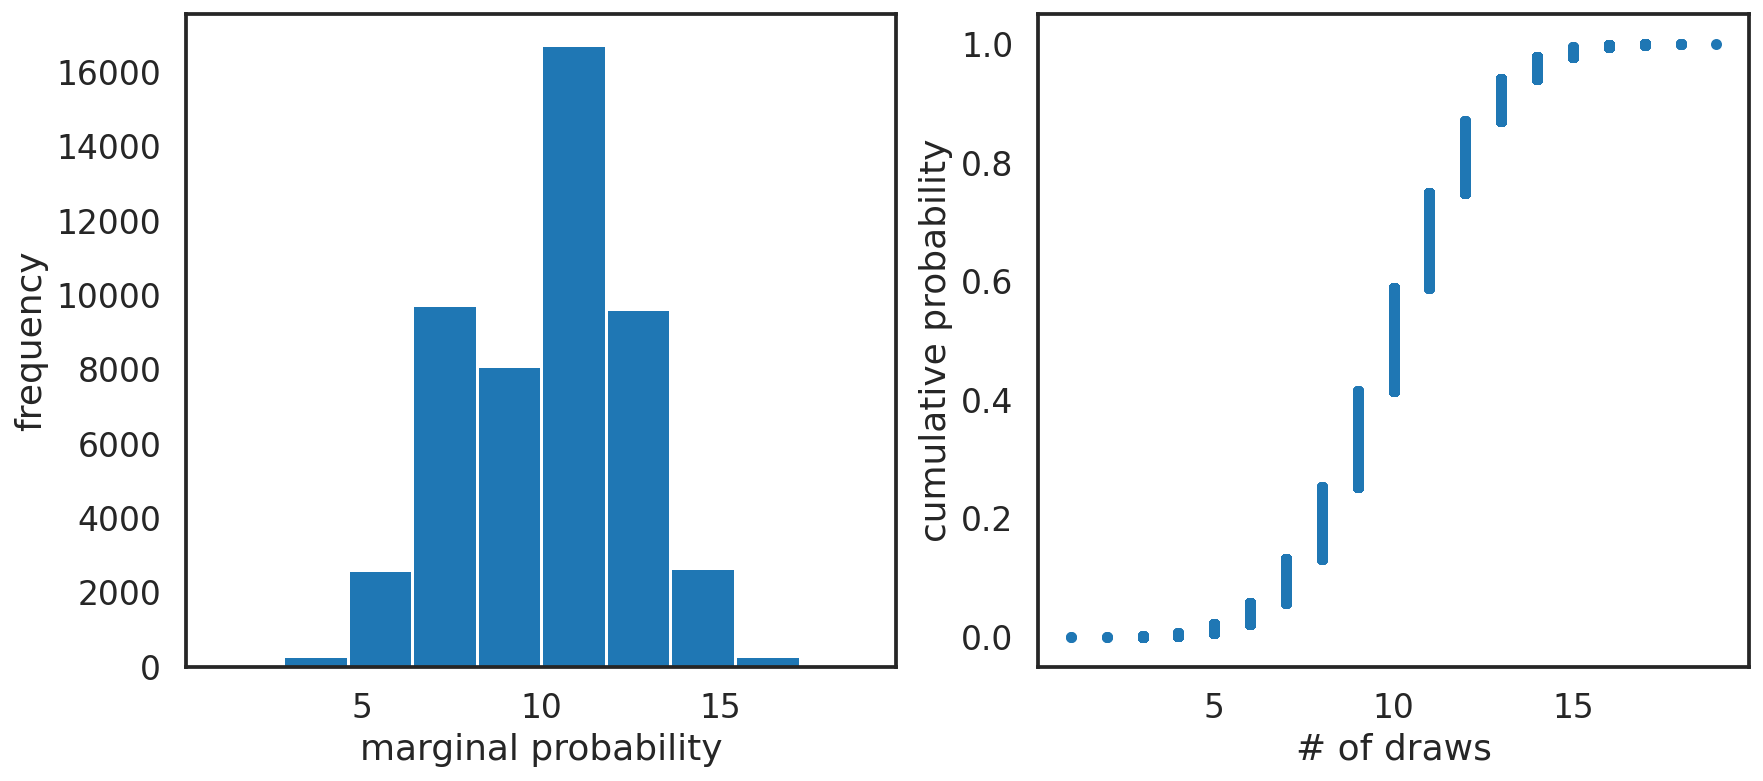

In [3]:
observations = np.random.binomial(20, 0.5, 50_000)
x_flips, y_flips = ecdf(observations)

fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].hist(observations, bins=10); 
ax[1].plot(x_flips, y_flips, marker='.', linestyle='none')

ax[0].set_xlabel('marginal probability')
ax[0].set_ylabel('frequency')
ax[1].set_xlabel('# of draws')
ax[1].set_ylabel('cumulative probability')


Text(0, 0.5, 'cumulative probability')

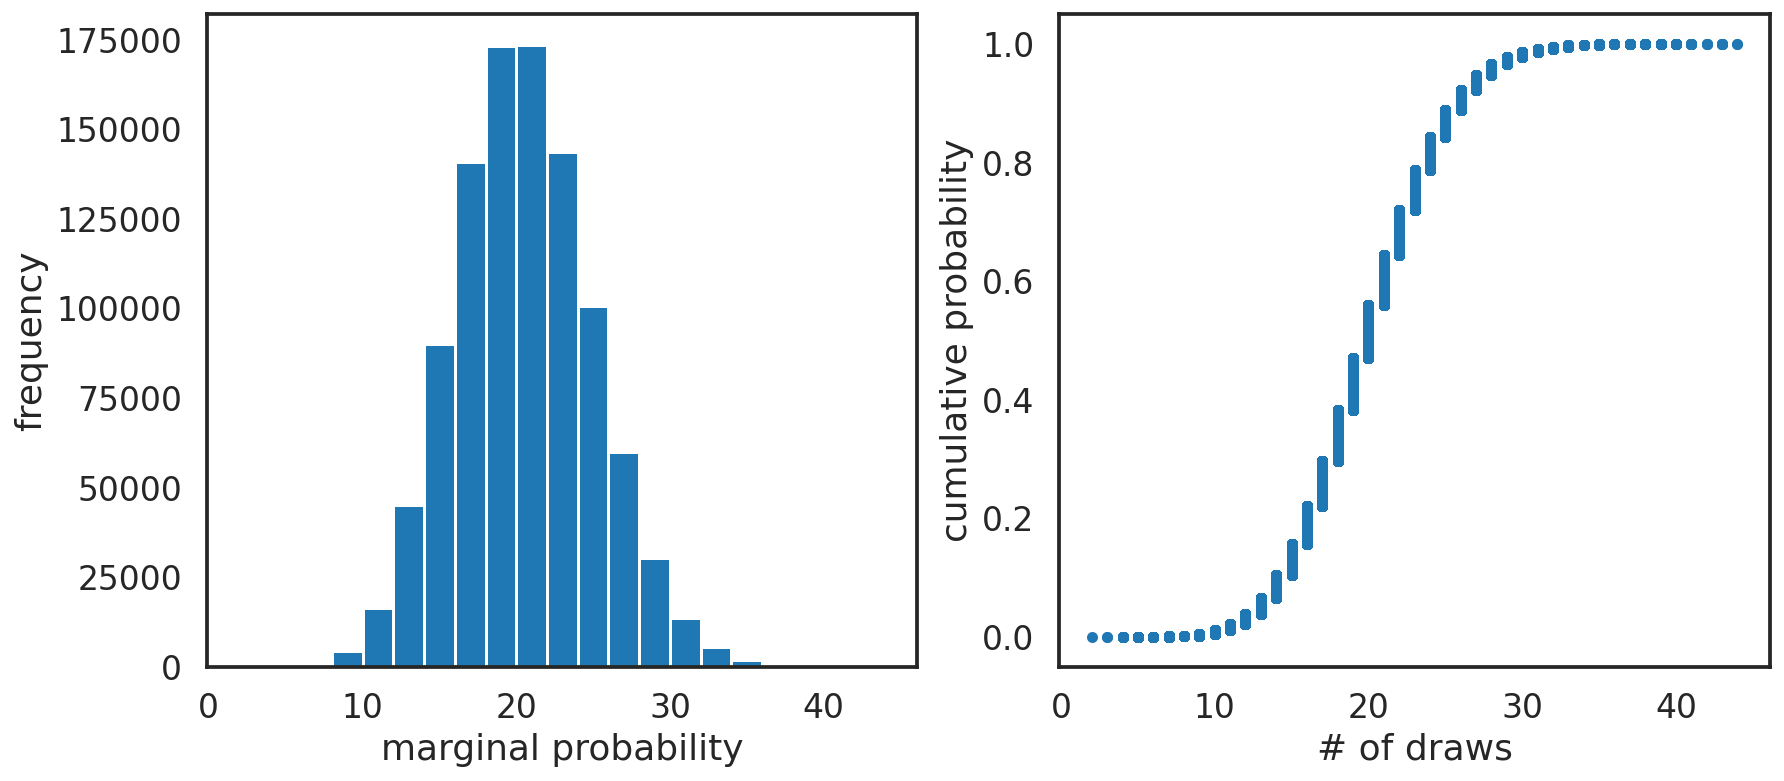

In [4]:
samples = np.random.poisson(20, size=10**6)
x_, y_= ecdf(samples)

fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].hist(samples, bins=21); 
ax[1].plot(x_, y_, marker='.', linestyle='none')

ax[0].set_xlabel('marginal probability')
ax[0].set_ylabel('frequency')
ax[1].set_xlabel('# of draws')
ax[1].set_ylabel('cumulative probability')

## Sunspots

See https://solarscience.msfc.nasa.gov/SunspotCycle.shtml


### Choosing the right distribution

In [5]:
sunspots = [96.7,104.3,116.7,92.8,141.7,139.2,158,110.5,126.5,125.8,264.3,142,122.2,126.5,148.7,147.2,150,166.7,142.3,171.7,152,109.5,105.5,125.7,116.7,72.5,75.5,94,101.2,84.5,110.5,99.7,39.2,38.7,47.5,73.3,58.3,83.3,118.3,98.8,99.5,66,130.7,48.8,45.2,77.7,62.7,66.7,73.3,53.3,76.2,63.3,60,52.8,36.7,65,46.7,41.7,33.3,11.2,0,5,2.8,22.8,34.5,44.5,31.3,20.5,13.7,40.2,22,7,17,18.7,11.3,10.8,0,0,14.3,5.3,29.7,39.5,11.3,33.3,20.8,11.8,9,15.7,20.8,21.5,6,10.7,19.7,23.8,28.3,15.7,23.5,35.3,43.7,50,63.5,21.3,41.7,85.5,66.2,54.2,107.8,55.8,62.7,86.7,81.7,120.5,77.3,75,73.3,64.5,104.2,62.8,71.7,71.7,80.5,73.3,78,78.3,81.7,83.3,85,118.8,128.7,99.5,77.2,95,112.2,99.2,124.5,97.2,120,80.5,110,126,102.2,84.3,99.5,101.7,116.7,151.7,134.5,119.5,178.7,165.5,156.8,151.8,167.8,147.8,149.5,76.7,73,121.3,76.2,100.3,66.5,128.5,56.3,112.8,114.2,115.5,129.7,128.7,94.2,53.2,57,54.8,54.5,59.7,90.3,44.2,113.5,77.2,101.5,102.3,99.5,99.5,67,57.3,73.8,50,50,50,47,46.7,43.3,42.8,40,43.3,41.7,36.7,33.7,33.3,45,49.5,26.7,23.3,23.3,21.7,20,18.3,61,10,44.7,5,5.5,6.7,7.2,8.3,9.5,32,45.7,50,71.7,54.8,49.7,55.5,36.5,68,71.2,73.5,91.2,88.8,89.2,110.2,77.2,71.2,129.5,129,87.7,111.3,124.7,129.7,151,186.3,123.2,107,107.2,161.2,122.7,157.3,197.7,200.5,248,263.7,246.8,186.7,173.3,237.5,133.5,85,116.8,138.8,183,210.5,174,172.7,220.3,170.5,60,77,77.8,108.2,254.5,199.2,112.8,97.5,169,150,166.2,159.5,168.2,151.3,51.8,153.7,63.3,95,128.8,93.7,84.2,131,102.2,106.7,91,48.3,85.3,54.8,68.5,47.3,46.2,21.2,48.8,43.8,68.2,72,78,109,92.8,73,85.5,47.5,29.2,11,13.2,23.3,29.5,20.3,7.3,0,19.3,18.7,6.5,20.5,1.7,13.2,5.3,9.3,25.2,13.2,36.2,19.3,10.5,36.3,18.7,31.7,1.7,40.3,26.7,50,58.3,66.7,75,60.8,65,159.2,133.8,134.5,158.3,186.7,193.7,177.5,243.3,262.2,295.5,182.2,223.3,241.7,398.2,286,255,233.3,286.2,260.5,250.5,175,191.2,276.2,196.7,241.7,233.3,189.5,238.3,186.7,185,206.7,190,183.3,116.7,163.3,163.3,158.3,178.7,146.7,143.3,143.3,156.2,128.3,100,97.8,164.5,124.5,88.3,113.8,174.5,162.8,122.5,110,85,45.5,111.7,58.7,90,62.5,61.7,68.3,90.5,63.3,61.7,73.3,56.7,38.7,52.5,50,46.7,64.5,44.5,47.2,38.3,42,53.7,33.3,30,13.3,25,17.5,21.7,13.3,18.3,16.7,10,15,10,16.7,16.7,13.3,28.3,23.3,10.8,13.3,15,26.2,34.5,43.8,60.5,33.3,53.3,78.7,67,45.5,62,79.3,79.5,142.3,153.8,98.3,138.3,149.5,185.8,187.2,193.3,187.8,224.5,176.7,145.7,212,224.7,165.3,213.3,228.7,262.2,261.7,235.8,290,230,215.3,238.8,180.8,188.3,257,235.8,226.7,235,236.7,157.8,215.8,190,208.8,200,205.5,205.8,200,195,171.7,186.7,149.5,223.3,225.8,171.7,212.5,160.5,156.7,155,151.7,115.5,145,128.8,140.5,136.7,123.3,121.2,103.3,123.3,128.7,122.8,107,118.3,71.7,110.8,102.8,111.7,110,96.7,106.7,105,126.2,103.3,101.7,76.3,100,98.3,98.3,95,93.3,93.3,91.7,92.5,88.3,87.2,85,83.3,48.8,40,78.3,73.3,76.2,75,73.3,63.3,47.3,92.8,69.2,68.3,66.7,18.5,47.5,112.3,85.7,35.7,66.5,21,31,51.7,28.5,21.5,42.8,22.5,32.5,41.7,30,36.7,39.7,26.2,52.8,35,11.2,44.8,2.5,30.7,18.3,14,8.5,24,7,6.7,6.7,12.2,18.5,7.2,10,9.5,11.5,9.7,5,3.3,6.7,20.7,1.8,0,0,0,5,4,2.5,20.8,16.5,2.7,21,36.2,14,13.7,17.7,3.5,0,0,7.7,4.5,14.3,11.5,15.5,23.2,0,8.3,39.5,35,32.5,19.2,20.5,17.5,66.8,45,48.3,50,51.7,53.3,52,58.3,64.5,55.8,54.3,66.3,80.3,79.7,78.3,68,70,73.3,76.7,80,83.3,86.3,64.2,57.5,83.3,83.3,84.7,49.2,41.7,73.8,60,80.5,56.8,75.5,90.5,85,80,75.5,80.5,80,84.3,55.7,58,49.7,71.8,88.3,103.8,101.7,100,101.7,73.5,85.7,62.5,65,67.5,62.7,71.2,74,49,68.3,63.8,65,49.3,54.5,46.2,44,42.7,50,43.8,40,45,41.7,40,20,20.3,16,39.7,16.7,20,21.2,20,9.5,13.3,4.3,0,0,7.5,0,20.5,22.5,22.5,11.2,13.3,19.5,7.8,17.5,20.5,12,15.3,1.5,4.2,3.3,12.8,0.5,0.3,0.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,4,10.2,1.3,1.8,18.8,3.2,1.2,0,1.7,2.2,0.8,26,8.7,6.5,13.2,16.8,0,17.2,3.2,27.7,9.2,18.7,30.5,14,25.5,46.3,27.8,23.8,37,20,9.5,39.7,9.7,24.8,30.8,3.8,13.5,32.2,24.2,33.5,32,53.7,43.7,52.7,16.3,93.2,59.2,78.7,52.5,55.8,62,108.3,43.8,114.7,122.8,98,73.8,72.7,64.7,38.7,79.7,94,63.5,49.8,60.7,96.5,160.3,44,35.3,66.7,83.3,75,61.2,42.7,48.2,47.3,58.1,37.4,42.4,57.5,88.5,60.8,46.8,52.6,43.4,52.8,18.3,43,54.7,34.6,6.3,33.7,32.6,58.3,52.5,43.5,24.8,45.9,41.8,50.9,32,44.4,7.5,32.3,48.9,17.9,34.1,43.1,8.6,14.9,13.2,15.1,36,7,9.5,15.2,2.8,3,4.3,8,7.3,31.4,7.3,0.4,0,1.5,26.9,21.7,2.4,9.3,13.2,3.4,0,0.6,0,0,0,0,1,0,0,0,0.8,0,0,0,0,34,36,18,0,32.3,4.6,0,0,2.3,34.3,42,0,1.4,8.4,25.9,37.4,6.2,25.8,25.6,51.5,42.8,26.2,26,19.6,36.7,29.4,30.2,61.3,40,53.9,61.7,87.5,66,31.6,84.4,65.8,113.6,57.7,79,96.3,76.7,93.8,94.4,70.4,89.4,82.6,93.5,80.4,76.8,88,107.3,108.5,101.9,148.6,163.4,90.4,127.3,83.9,91.1,95,78.1,71.6,82.3,120.6,158.4,112.3,123.2,151.5,129.3,88,95.3,112.7,94.1,87,120.1,141,177.3,110.5,108.4,73.2,84.6,103.4,140.6,135.4,136.8,79,83.6,155.8,90.9,63.4,55.6,75.4,91.6,63.2,77.1,72.5,48.3,51.5,92.6,91.9,44.8,68.9,44.5,23.3,14.8,13.7,35.2,23.8,45.8,18.7,24.9,19.6,4.6,21.5,1.7,11.6,9.5,19.3,12.5,9.8,16.6,8.2,30.1,6.5,2.4,14.8,13.1,14.4,6.6,19.2,41.3,50.9,57.5,12.4,40.7,32.7,102.4,72.6,55.2,99.6,98.5,168,158.6,166.7,129.3,147.6,179.4,163.7,238,185.7,207.9,194.6,179.6,158.5,228.9,201.5,343.8,313.4,292.6,224.3,230.3,186.1,263.4,271.2,223.5,160.4,206.2,178.4,216.1,241.5,141.3,234.5,211.1,229.4,157.6,180.4,131.3,122.7,151.5,129.2,132.9,175.9,170.8,129.5,102.9,89.6,91.2,141.3,218.8,221.1,151.5,114.7,106.2,135.4,146.1,112.9,109.8,115.4,80.9,101,96.4,123.3,91.7,90.4,89.5,40.1,49.9,49.6,66.9,112.4,92.8,51.4,65.4,60.9,47.4,32.9,64.8,34,36.8,36.2,44.9,41.4,34.2,21,44.4,30.6,63.5,67.5,29.3,22.2,5.9,13.9,15.8,35.1,17.6,15.9,19.6,6.9,8.9,31.7,21.2,15.7,24.5,22.5,34.6,19.2,6.2,35.2,39.7,11.6,35.9,17.9,36,42.8,72.8,72.1,95,79.7,51.8,51,53.9,49.3,67.8,65.7,99.5,64.6,84.9,106.5,115.5,99.9,108.4,77.5,91.3,178.6,93.4,100.6,109.1,104.4,74.9,143,74.6,125.7,142.2,87.1,234.3,268.2,300.6,231.5,182.6,265.2,186.4,181.2,178.6,170.5,214.9,232,220.9,167.3,220.6,191,265.8,298.3,250.3,182.7,194.7,153.2,154.2,148.2,128.6,178,135.7,188.2,184.3,148.2,169.8,156.8,83.8,117,133,74.3,117,163.7,134.9,104.1,115.9,143.5,200.1,122.8,107.3,118.9,120,68.6,109,128.9,118.7,96.8,135.5,129.9,126.2,116.2,124.3,104.3,89,80,75.3,71.2,127.9,103.1,86.1,77.9,81.5,71.6,90.4,65.9,76,87.2,95.8,63.7,80.5,54.7,44.5,29.3,38,39.4,50.3,45.6,40.1,35.5,30.1,42.6,24.1,53.5,41.1,23.4,21.6,33,8.4,17.3,10,0.7,5.9,0,18.3,7.9,5.8,1,9.3,0.7,12.4,0,9.8,8.8,11.3,8.4,8.5,14.7,13.7,26,14.2,10,21.1,54.2,30.5,42.2,32,80.6,77.1,59.6,70.7,74.2,66.3,109.2,72.8,78.6,84.5,107.7,104.9,152.2,173.2,98.6,127,159,166.4,171.5,162.9,172.8,165.2,180.7,203,200.9,217.8,184.6,153.9,156.6,167.9,188,135.7,203.5,206.3,221.9,190.5,175.2,171.1,186,181.7,118.5,147.5,192,187.1,107.8,167.5,148.2,156.7,151.9,127.7,102,152.8,119.9,122.4,82.7,102.1,122.4,159.7,139.5,118.7,126.4,79.8,96,77.6,91.8,107.7,126,77.1,102.1,77.6,62,91.3,41.7,75.7,71.6,78.1,109.7,89.5,125.9,68.1,77.1,109.9,103.8,104.1,54.2,64.4,109.3,54.3,92.5,74.6,75,55.9,65.6,63.8,50.8,71.8,41,32.5,46.7,24.3,60,72.9,46.6,33.5,24.6,31.4,17.6,24.2,13.9,26.8,17.2,2.9,0,1.4,17.4,9.7,5.5,2.8,9.5,9.1,18.7,25.5,18.1,47.9,25.9,26.3,44,61.1,44.5,51.8,48.3,57.3,78.7,102.8,98.7,112.8,101.6,99.9,88,68.4,173.4,180.7,98.8,132.7,134.5,99,130.2,174.1,129,191.7,262.7,266.9,293.6,226.3,220.9,256.5,226.8,244.3,246,216.7,147.2,209,238.7,270.9,242.6,152.9,171.8,183.7,133.9,148.5,175.7,150.8,132.7,200.3,147.5,170.4,179.5,183.3,176,155,191.1,171.2,186.8,139.9,144.6,178.4,164,127.1,80,74.8,111.7,113.8,78.7,78.6,92.5,82,101.4,107.1,77.5,53.5,74.6,63.8,113.2,102.3,46.8,57.4,48.2,48.8,24.4,35.9,56.4,48.6,19.2,39.9,20.9,24.4,4,21.3,29.6,16.5,23.9,25.1,51.1,3.9,8.5,2.7,25.5,14.8,16.6,23.9,16.6,13.6,40.6,14.5,19.9,26.3,36.1,23.6,10,10.5,28.1,11.2,23.6,3.5,5.5,11,13.1,0.2,9.9,10.7,0.2,0,8.8,1.9,6.8,0.9,1.6,0.9,0,10.4,4,8,12.6,17.9,10.1,20.4,21.9,12.2,40.1,45.4,32.1,32.4,39.1,56.9,36.5,80.3,110.1,71.7,51.1,49.4,60.6,88.6,85.8,86.1,72.5,100.8,128.2,97.3,88.6,107.3,91.5,78.8,75,115.9,111.5,159.6,106.9,75.4,75.7,67.5,96.1,98.6,140.6,69.7,101,78.2,71.3,136.8,52.5,127.2,134.4,76.6,87.8,139.6,140.8,126.5,152.6,144.8,145.8,126.9,110.9,85.3,88.5,93.1,103.1,79.6,60.9,78.6,71.4,119.7,82.9,91.7,121.6,139.5,110.9,83.5,66,64.5,51.6,36.3,49.8,43.2,95.5,72.9,51.2,45.3,50.4,28.1,35.7,14.4,0.6,21.7,17,22,7.1,11.6,33.4,26.1,38.9,35.7,12.4,11,11.5,34.5,21.2,11.8,13.1,8.5,11.7,11.8,5,4.6,14.6,3.4,17.9,11.1,1.3,14.2,11.1,7.3,4,10.8,15.8,34.3,10.9,3.4,0.3,11.2,8.8,1.1,8.5,2.7,7.9,2.2,19.3,14.2,28.6,18.6,15.9,13.1,22.5,36.9,17.2,34.2,68.5,80.4,98,55.1,89.7,86,69.8,54.3,115.2,126.1,83.3,116,132.7,127.3,127.6,169,104.7,117.5,108.9,131,125,121.6,109.5,146.8,141.3,149.8,147.6,215.4,129.9,133.3,125.2,156.4,138.6,141,87.1,136,168.7,164.8,176.7,117.1,110,125.7,94.3,100.1,105.4,112,101.6,128.2,112.5,119.1,79.7,114.9,96.1,113.2,78.6,117.9,48.4,95.7,86.5,73,46.1,81.7,75.2,45.4,102.2,47.9,63.3,71,67.6,49,48.7,51.7,33.3,18.9,46.1,36.4,80.4,23.9,14,55.5,50.4,60.7,63.9,24.2,43,37.1,15,52.3,58.1,57.1,51.6,21.1,32.4,15.3,30.3,23.6,12.9,34.1,22.5,4.9,14,21.7,13,17.6,15.7,22.8,14.4,26.8,25.3,20.1,13.9,7.1,13.9,21.6,7.5,0.5,0.4,4,7.4,0,17,9.7,1.2,1.7,0.9,6.3,6.4,0,9.3,0,20.7,0,4.7,2.4,1.5,3.8,12.6,27.2,17.2,1.8,13.9,28.4,22.5,43.5,24.3,27.2,46.4,48,18.5,64.8,74.2,76.2,52.6,40.8,61.9,71.6,65.7,69.8,84.3,97.1,50.2,90.4,63.4,91.1,91.2,143,94.3,65.5,79.9,81.6,121.6,98.1,91.8,131.2,178.7,92.5,75.8,52.3,107.4,92.2,96.2,105.3,172.7,79.6,93.5,29.7,64.8,108,127.4,180.3,101.1,87.6,71.4,67.2,82.9,90.5,141.7,109.1,102.5,78.9,65.4,56.6,47.9,96.1,68,80.2,65.8,150.9,144.9,53.9,75.9,65.9,94.6,77.6,110.5,53.7,60,37.8,59.6,38.5,64.7,97.4,93,90.2,44,52.5,35.7,14.1,36.9,20.5,23.5,19.3,43.7,63.9,8.3,9.6,5.6,15,13,27.6,15.1,3.7,5.9,6.7,6.7,4.5,7,3.7,0.4,0,8.2,7.6,7.4,6.9,4.9,0.5,15.9,7.6,1.9,10.6,3.8,4.8,0.8,1.6,0,0,2.9,0.4,2,5.2,1.2,6.3,4.7,4.4,5.3,28.9,8.7,19.1,9.1,12.9,21.2,13.7,27.3,37.3,38.5,70.4,64.8,68.9,55.1,114.7,119.4,116,82.4,89.1,70.9,57.5,75.5,92.4,111.7,119.8,124,112.9,89.3,58.6,75.1,84.5,109.5,88.3,124.5,119.9,158,124.6,190.2,191.4,199.7,257.7,215.6,120.3,160.7,215.5,160,108.7,120.4,134.1,127.9,99,179.5,169.6,133.2,141.7,139,98.5,80.2,132.5,110.9,86.3,146.9,185.3,107.8,115.1,91.1,88,69.9,58,85.3,89.8,116.9,24.7,55.4,64.6,45.7,31.9,60.5,82.7,45.3, 49.8,52.5,47.1,44.5,54,37,56.2,69.7,38,29.6,30.3,29.6,33.9,19.7,43.9,91.3,18.3,13.4,9.8,18.3,10.9,7.8,10.4,12.2,29,7.5,2.5,5.5,10.2,5.3,15.3,5.9,0.8,22.1,19.5,16.7,4.6,0.8,8.5,3,18.9,34.6,40,46.9,32.1,41.9,42.6,37.5,27.5,9.1,38.6,30,53,71.4,79.1,64.2,63.3,100.3,115.3,97.6,164.4,119.7,116.4,104.2,64.2,107,122.4,87.2,102.7,101.4,119.3,100.8,132.4,136,155.1,116.1,155.8,131.9,98.5,91.6,89.6,114.1,105.2,112.1,75.3,139.2,122.4,142.4,134.3,128.3,152.4,163.4,139.6,149.6,102.3,83.9,98.3,114.8,104.7,83.8,87.9,97,119.9,117.1,109.6,57.3,90.1,135.1,179.9,108.8,83.1,58.4,63.7,61.4,48,36.5,41.5,53.5,57.2,59.4,43,24.4,71.8,50.1,52,40.8,25.5,29,21.6,31.7,16.6,31.2,29.7,20.1,17.6,18.8,18.7,29.7,36.9,16,11.3,6.6,14.8,13.7,18.5,20.4,36.9,16.8,4.9,5.3,8.7,4.7,0.4,8.5,5,1,0.4,5.7,12.9,7.2,18.8,32.9,11.2,15.3,13.9,6.7,9.5,14.5,25.7,31.1,34.1,38.5,20.4,45.4,76.2,56.5,50.2,70.1,88.7,107,102.5,104.7,123.9,128.4,124.8,90.9,116.7,87.2,145,126.7,148.2,192.3,205.6,220.9,214.1,139.7,182.2,194.4,217.1,241.8,229.5,167.9,208.2,123.9,147.9,164,198.6,144.2,168.4,212.3,162.6,275.6,192.8,149.3,165.3,203.6,154.7,133.9,129,107.8,181.9,197.3,168.3,162.6,176.3,187.7,146.9,113.7,70.2,84.1,99.1,138.9,101.1,90.6,139.8,112.5,175.9,110.8,91.5,97.4,113.8,76.1,74.3,77.5,54.6,49,99.6,111.4,100.1,109.8,77.2,64,56.2,59.5,87.9,90.4,101.2,41.8,18.9,29.6,33.7,28.7,32,51.3,37.6,20.7,48.1,45.7,43.5,23.6,12.7,22,32.3,16.7,13,17,31.4,6.1,0.8,18.3,0.4,4.1,8.2,8.5,27.9,23.7,28.1,17.9,47.4,30.8,21.2,35.9,53.4,51,60.2,71,43.1,58.1,114.5,76.6,45.7,79.3,143.8,127.7,126.1,141.6,122.6,193.7,178.7,157.4,170.5,206.3,202.9,163.7,188.9,183.8,212.1,285,232.1,223.5,267.4,239.9,231.7,181.3,164.9,153.6,122,134.3,268.5,246.4,237.5,201.4,223.7,202.9,192.9,135.6,195.3,168.6,258,223,208.1,150.4,172.4,178.3,175.3,205.8,186.3,203.2,166.6,143.9,134.3,155.4,160.6,150.5,118.3,128.9,120.6,72.7,87,77.7,76.7,85,84.8,79.3,131.7,153.7,142.4,87.2,86.5,117.7,73.3,74.2,65,57.9,32.4,31.5,41.7,33.6,52,56.1,77.8,40.4,34.2,31.8,48.9,37.9,5.9,14.7,39.6,18.3,31.5,12.7,33.6,28,12.3,2.5,3.9,0.4,0.8,15.8,2.7,1.2,0.4,7.3,12.6,2.3,10.5,13.4,11.3,33.4,29.9,7.3,16.4,41.3,45.2,38.2,58,60.8,83,126.3,108.8,104.1,175.6,167.7,156.7,193.4,165.1,182.7,240.2,245.4,219.9,285,272,233.7,184.5,222.8,248,233,284.3,265.1,223.7,334,359.4,298.6,339,286.7,233.6,270,277.6,248.2,242.9,271,283.5,285.1,256.9,215.6,265.7,307.7,202.6,263,231.3,243.6,238.9,211.9,282.6,205.6,157.7,175.6,177.1,207.2,149.9,144.6,172.7,169.3,156,172.4,190,180.1,117.3,126.9,121.2,82.1,65.4,75.2,86.9,72.3,109.5,99.3,79.2,90.1,53.7,46.5,56.9,55.1,71.7,64.9,65.9,61.9,59.6,31.4,31.5,72.7,56.1,38.8,33.2,28.7,35.2,24.8,41.7,61.1,51.2,28.7,47.5,55.2,50.1,33.7,21.6,22.6,25.3,24.1,12.9,14.3,13.5,4.8,13.8,7,9.2,11.1,22.1,25.4,20.8,17.5,10.2,34.5,23.3,17.3,13.3,24.5,29.1,22.8,24.7,40.3,35.3,36.4,69,64.2,67.7,80.2,72.6,71.1,81.2,81,99.8,157,132.6,158.3,98.4,122.5,95.4,129.5,151.8,108.7,125,133.6,179,172.5,158.5,130.5,115,180,156.2,136.2,154.8,166,152.5,121.7,155.5,147.8,170.5,192.3,151.1,169.9,150.1,137.1,138.8,129.3,135.4,132.4,138.6,157.9,180.8,145.7,155.1,180.5,151.3,159.3,131.7,140.8,122.6,134.8,118.2,129.2,111.8,85.9,101.6,81.5,70.7,114.7,87,71.3,73.4,89.5,116.5,87,125.3,113.5,89.6,113.9,124.7,108.3,108.9,90.7,86.9,59.2,64.3,61.8,60.9,65.4,81.8,60.3,56.1,33.2,36.6,84.1,43.7,34.3,33.3,39.4,37.3,30.9,57.5,56.3,51.5,79.1,47.9,57.2,67.2,35.9,29.6,27.3,16.7,16.9,7.7,13.1,16.7,40.4,56.7,20.3,13.6,27.9,11.6,11.9,6.4,31.5,27.3,18.2,17.9,2.9,24.1,20,29.7,7.9,22.3,23.8,33.3,13,19,27,54.9,30.6,43,62.4,62.1,41.6,61.4,73.7,132.6,108.4,141.2,117.1,134.6,99.7,82.4,195.7,177.1,138.5,173.9,235.9,194.7,195.3,143.7,190.3,211.7,225.7,201.4,266.9,263.6,259.5,249.6,226.1,219.4,178.7,232.2,254.7,222.7,192.9,191.7,219.6,233.3,209.5,246.9,156.6,189.9,196.6,225.3,194.7,131.6,205.3,242.5,245.3,216.2,186,195.4,149.8,230.9,221.1,170.3,119.3,163.7,139.4,161.9,167.4,134.3,127.5,169,115.5,73.1,88.7,109.6,132.5,131.5,108.9,96,69.9,72.5,45.7,45.6,74.8,110.2,116.7,90.4,96.9,65.1,55.7,35,22.6,12.6,26.5,21.4,17.8,20.7,16.9,20.4,32.4,28.3,39.9,10.1,4.3,22,17.9,15.8,2.8,27.9,13.8,22.4,16.1,0.6,18.1,9.9,5.1,40.1,15.4,5.8,9.8,3.4,17.4,46,39.1,18.8,38.2,47.9,42.2,63.4,48.8,29.1,70.5,45.4,91.2,108.8,74.2,124.3,131.4,139.4,142.7,156.5,156.8,231.2,210.1,208.7,170.4,166.3,195.4,284.5,180.5,232,225.1,212.2,238.2,211.4,227.4,171.8,191.7,189.7,175.2,153.3,191.1,252.1,169.1,199.4,178.8,197.1,195.3,240.3,197,197.6,166.9,224.7,240.2,240.8,168.9,197.1,159.5,212.6,198.3,230.7,151,142.2,94.3,98.5,114.2,91.9,94,133.4,129.6,122,81.4,127.8,102.4,94.4,78.8,69.6,80.4,62.5,31.2,71.1,48.2,68.4,84.9,54.9,47.5,27.4,29.8,39.7,50.6,34.3,40.5,67.1,29.5,32.2,32.6,45.8,46.3,21.6,19.4,22.5,20.4,18.2,15.7,30.6,14,14.9,13.3,7.7,12.6,6.8,7.6,16.5,11.8,19.7,3,0.7,24.9,14,7.4,11,12.1,23,25.4,20.8,12.9,35.7,59.7,32.8,50.4,55.5,44.5,50.2,82,70.6,74,90.5,96.7,121.1,132,78.5,97.3,119.2,86,98,103.5,93.6,149.6,207.2,173.5,142.3,106.3,168.7,188.3,116.8,133.1,165.7,217.7,191.5,165.9,188,244.3,180.5,156,141.6,158.1,143.3,142.6,121.5,165.8,161.7,142.1,202.9,123,161.5,238.2,194.1,176.6,213.4,184.6,170.2,147.1,186.9,187.5,128.8,161,175.6,187.9,151.2,147.2,135.3,133.5,75.7,100.7,97.9,86.8,118.7,128.3,115.4,78.5,97.8,82.9,72.2,60.6,74.6,74.8,59.2,72.8,66.5,83.8,69.7,48.8,74.2,70.1,28.9,48.1,43.5,39.6,38.7,61.9,56.8,62.4,60.5,37.2,13.2,27.5,59.3,20.9,5.7,17.3,50.3,37.2,24.5,22.2,20.8,23.7,14.9,35.7,22.3,29.3,18.4,7.2,5.4,19.5,21.3,15.1,9.8,4,1.5,2.8,17.3,4.1,2.9,15.5,3.6,4.6,5.2,0.6,0.3,1.2,4.2,6.6,1,1.3,1.2,0.6,1.2,2.9,6.3,5.5,0,7.1,7.7,6.9,16.3,19.5,28.5,24,10.4,13.9,18.8,25.2,29.6,36.4,33.6,34.4,24.5,27.3,48.3,78.6,76.1,58.2,56.1,64.5,65.8,120.1,125.7,139.1,109.3,94.4,47.8,86.6,85.9,96.5,92,100.1,94.8,93.7,76.5,87.6,56.8,96.1,60.9,78.3,107.3,120.2,76.7,86.2,91.8,54.5,114.4,113.9,124.2,117,146.1,128.7,112.5,112.5,102.9,100.2,106.9,130,90,103.6,112.9,93,66.7,54.5,75.3,88.8,66.5,65.8,64.4,78.6,63.6,62.2,58,57,56.4,54.1,37.9,51.5,20.5,32.4,50.2,44.6,33.4,21.4,18.5,26.1,26.4,17.7,32.6,18.8,19.4,18.3,33.1]

Text(0.5, 0.98, 'The actual empirical distribution')

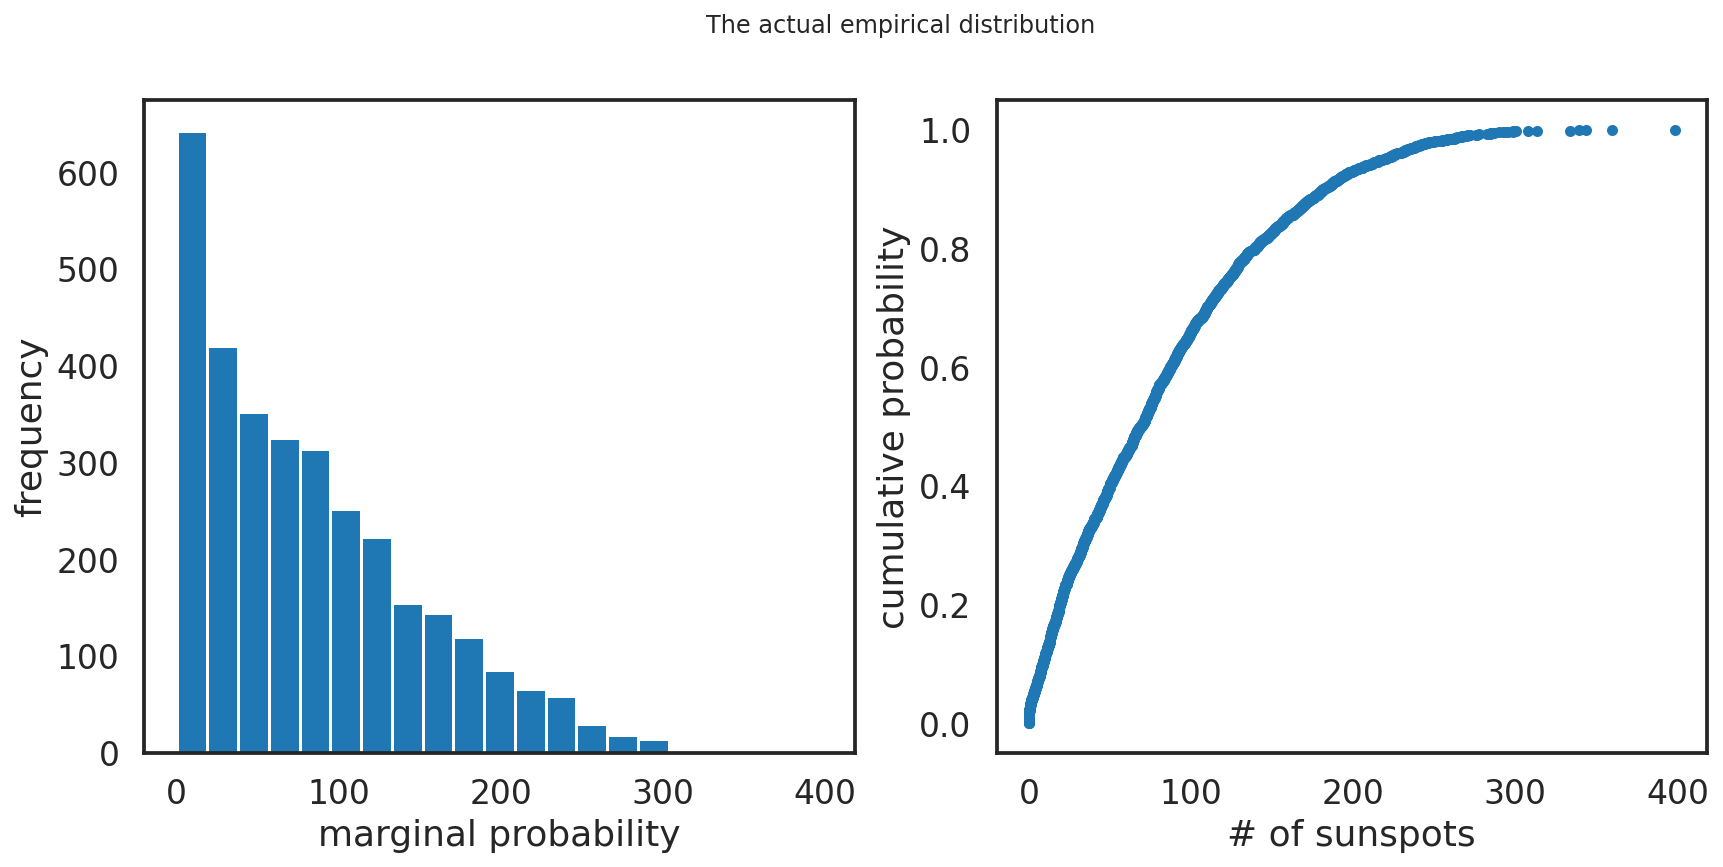

In [75]:
x_obs, y_obs = ecdf(sunspots)

fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].hist(sunspots, bins=21); 
ax[1].plot(x_obs, y_obs, marker='.', linestyle='none')

ax[0].set_xlabel('marginal probability')
ax[0].set_ylabel('frequency')
ax[1].set_xlabel('# of sunspots')
ax[1].set_ylabel('cumulative probability')
fig.suptitle("The actual empirical distribution")

This looks a bit like the half of a Cauchy, or the half of a Normal distribution.
Let's try to find the best estimation of this data, using 
* PyMC3 
* SciPy

### PyMC3

Text(0, 0.5, 'cumulative probability')

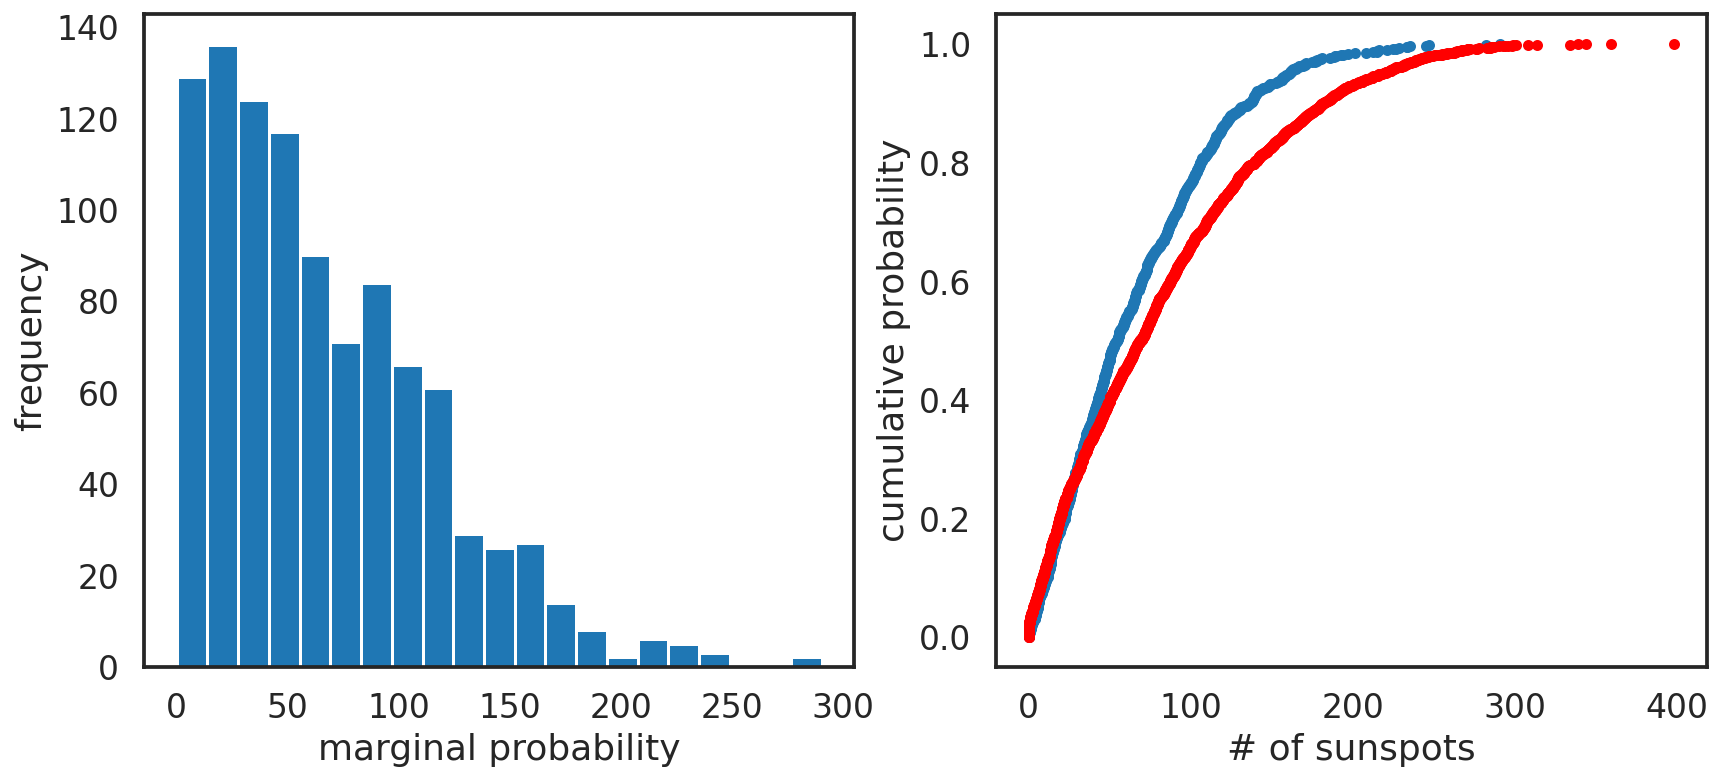

In [81]:
mod_simple = pymc3.distributions.HalfNormal.dist(sigma=np.mean(sunspots))
simple_samples = mod_simple.random(size=1000)

x_ss, y_ss = ecdf(simple_samples)

fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].hist(simple_samples, bins=21); 
ax[1].plot(x_ss, y_ss, marker='.', linestyle='none')
ax[1].plot(x_obs, y_obs, marker='.', linestyle='none', color='red')

ax[0].set_xlabel('marginal probability')
ax[0].set_ylabel('frequency')
ax[1].set_xlabel('# of sunspots')
ax[1].set_ylabel('cumulative probability')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains, 187 divergences: 100%|██████████| 12000/12000 [00:02<00:00, 4173.20draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6199513286119692, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed 

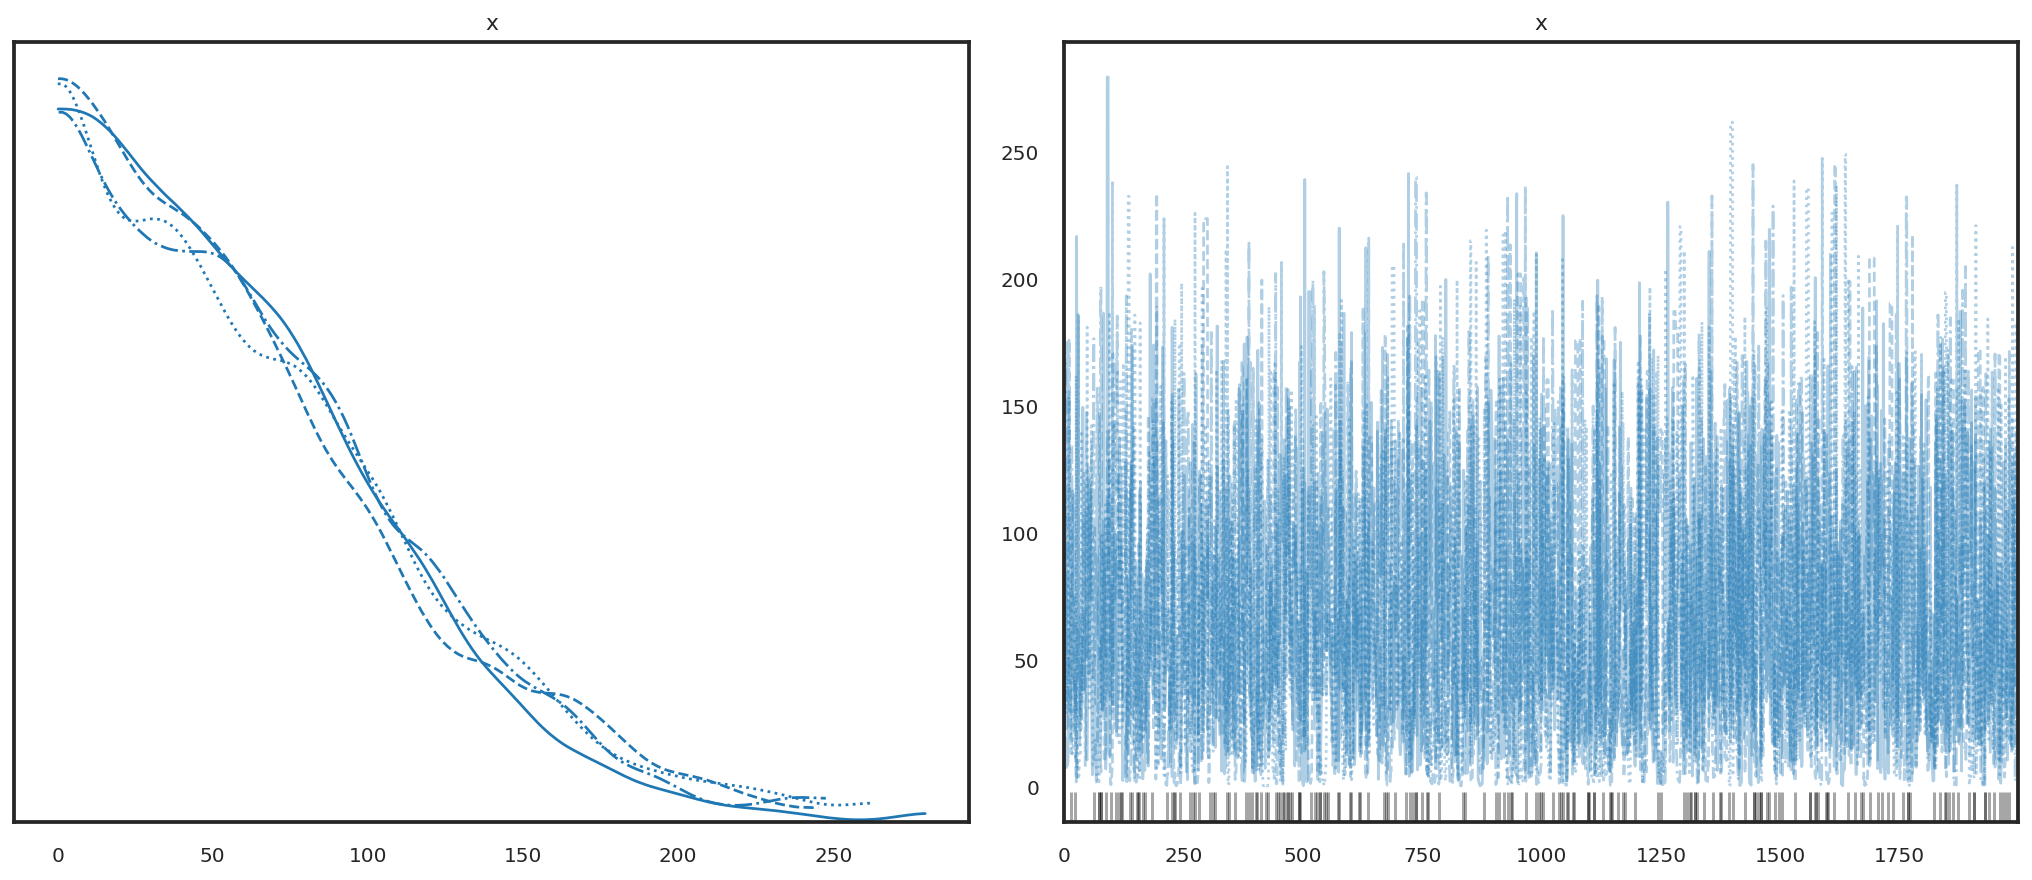

In [70]:
# define your model
with pymc3.Model() as sunspot_model:
    x = pymc3.distributions.HalfNormal('x', sigma=np.mean(sunspots))
# extract samples
with sunspot_model:
    tr = pymc3.sample(2000, tune=1000)
# plot a specific variable
pymc3.traceplot(tr, varnames=["x"], figsize=(14,6));   

In [82]:
less_simple_samples = sunspot_model.x.random(size=1000)

x_lss, y_lss = ecdf(less_simple_samples)

fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].hist(less_simple_samples, bins=21); 
ax[1].plot(x_lss, y_lss, marker='.', linestyle='none')
ax[1].plot(x_obs, y_obs, marker='.', linestyle='none', color='red')

ax[0].set_xlabel('marginal probability')
ax[0].set_ylabel('frequency')
ax[1].set_xlabel('# of sunspots')
ax[1].set_ylabel('cumulative probability')

AttributeError: 'Model' object has no attribute 'x'

### SciPy

Text(0, 0.5, 'cumulative probability')

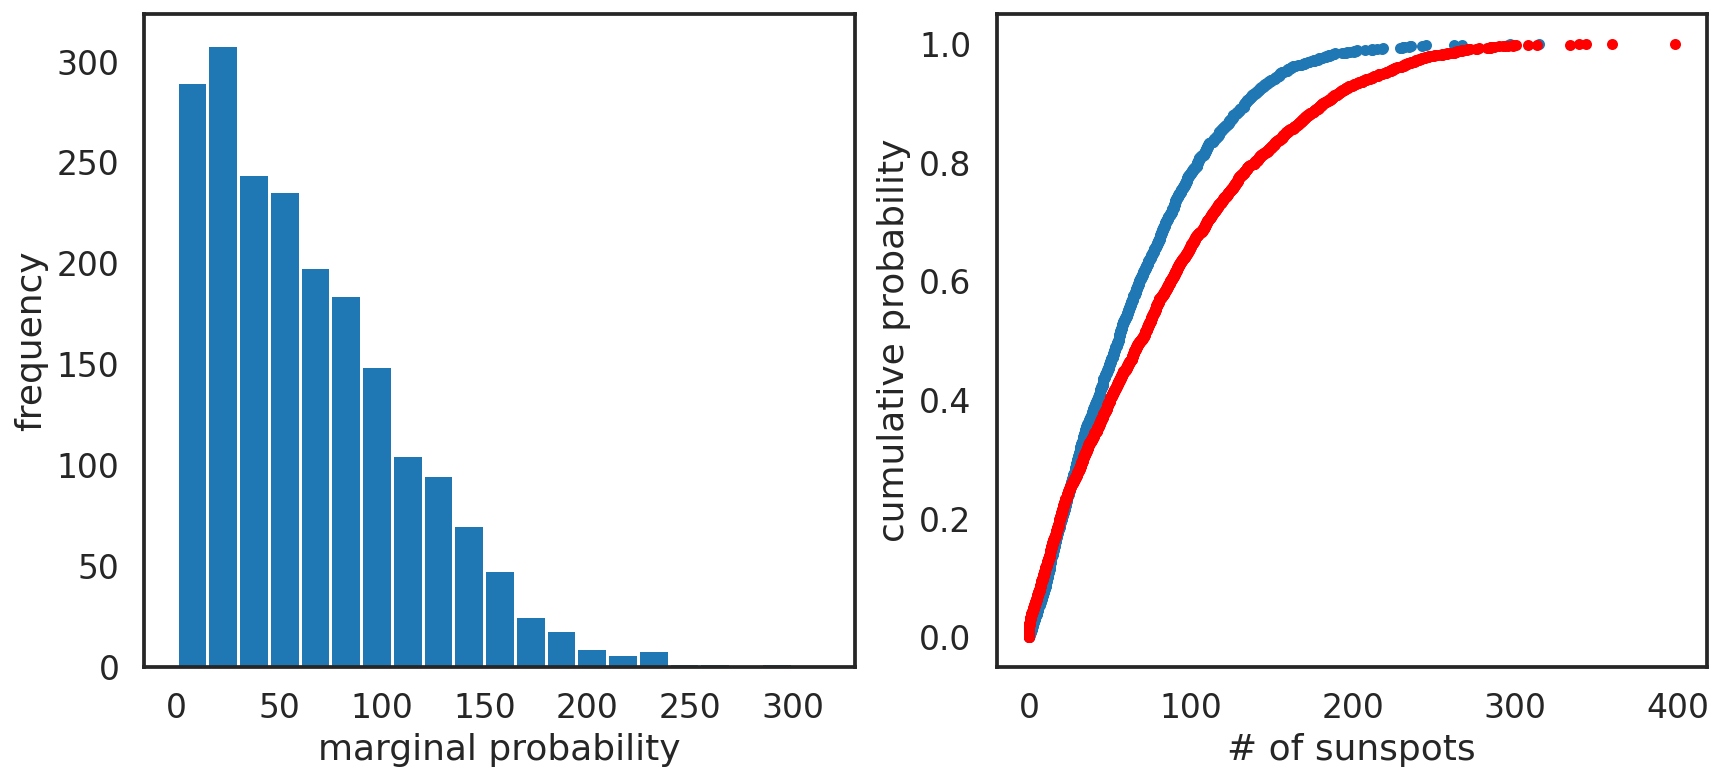

In [83]:
sunspot_model = sc.stats.halfnorm
x_sc = sunspot_model.rvs(loc=0, 
                  scale=np.mean(sunspots), 
                  size=2000, 
                  random_state=123)

x_mod, y_mod = ecdf(x_sc)

fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].hist(x_sc, bins=21); 
ax[1].plot(x_mod, y_mod, marker='.', linestyle='none')
ax[1].plot(x_obs, y_obs, marker='.', linestyle='none', color='red')

ax[0].set_xlabel('marginal probability')
ax[0].set_ylabel('frequency')
ax[1].set_xlabel('# of sunspots')
ax[1].set_ylabel('cumulative probability')

### We have the right distribution, now we have to find the right distribution parameter

We need to add **observations** to our model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:02<00:00, 4730.93draws/s]
/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


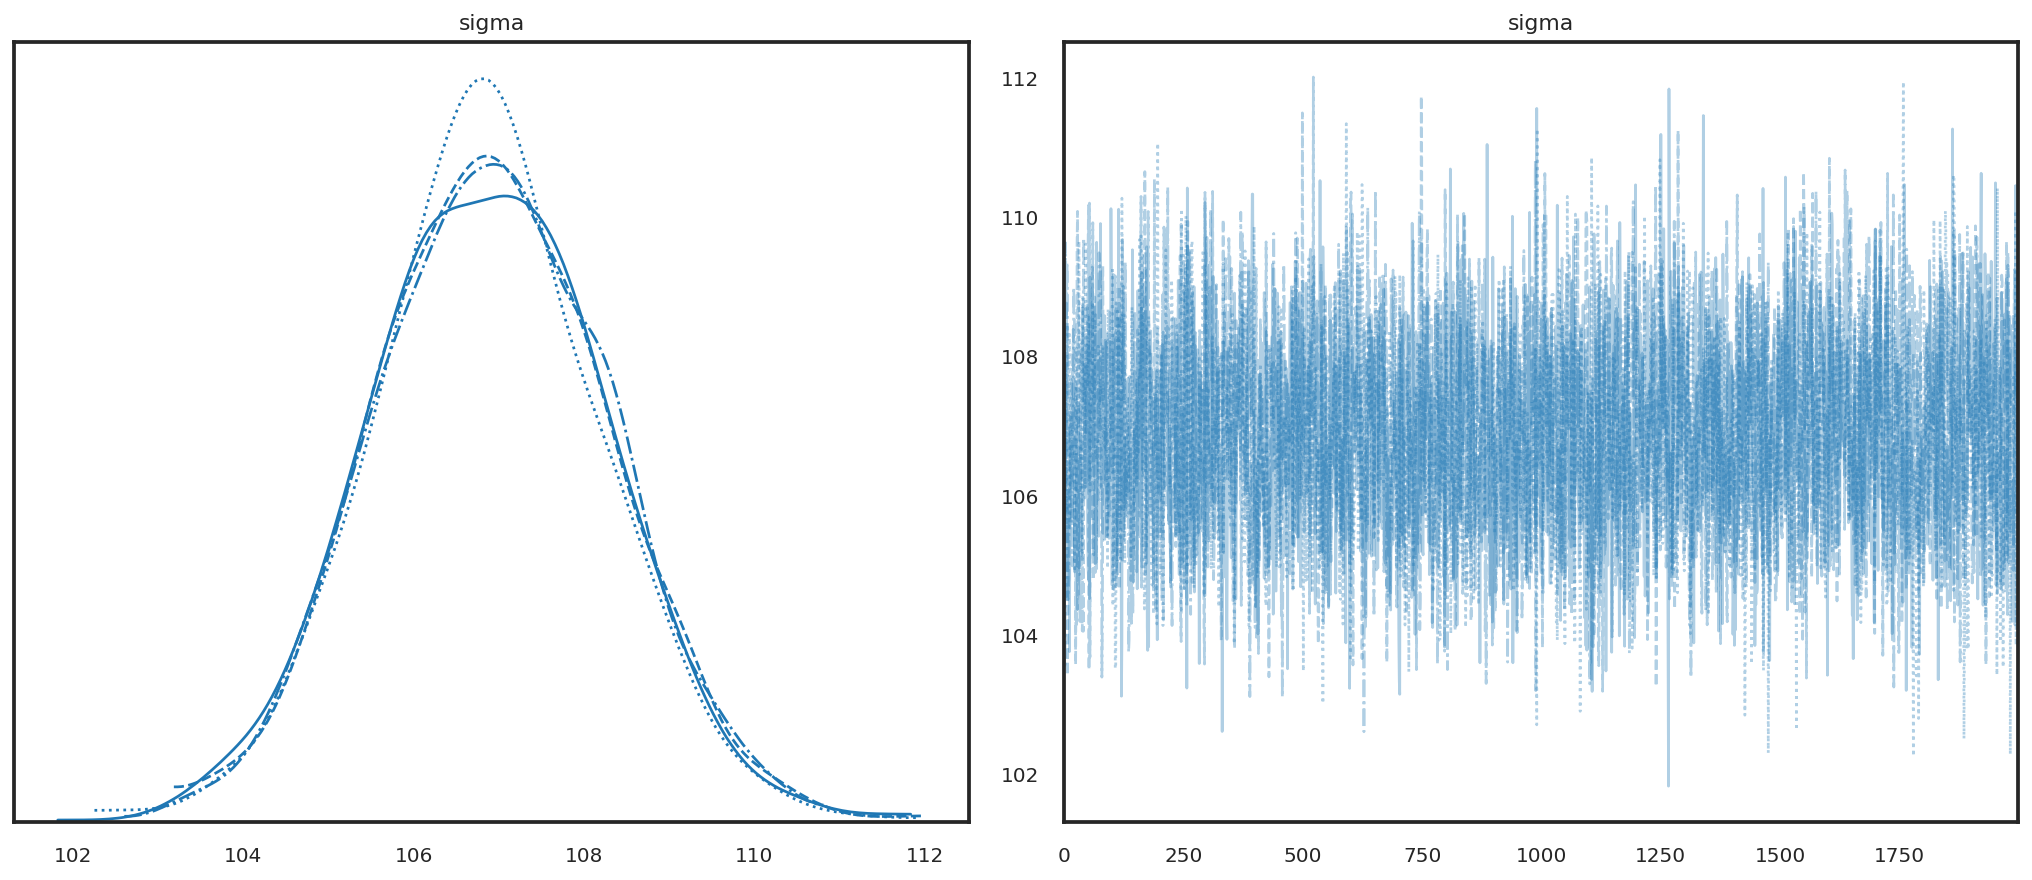

In [80]:
# define your model
with pymc3.Model() as sunspot_model2:
    # PRIOR
    sigma = pymc3.distributions.Normal('sigma', mu=np.mean(sunspots), sigma=20) 
    
    # LIKELIHOOD
    observed = pymc3.distributions.HalfNormal('observed', sigma=sigma, observed=sunspots)
    
# extract samples
with sunspot_model2:
    tr = pymc3.sample(2000, tune=1000)
# plot a specific variable
pymc3.traceplot(tr, varnames=["sigma"], figsize=(14,6));   

INFO (theano.gof.compilelock): Refreshing lock /home/koekiemonster/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


Text(0.5, 1.0, "Sample of 50 CDF's")

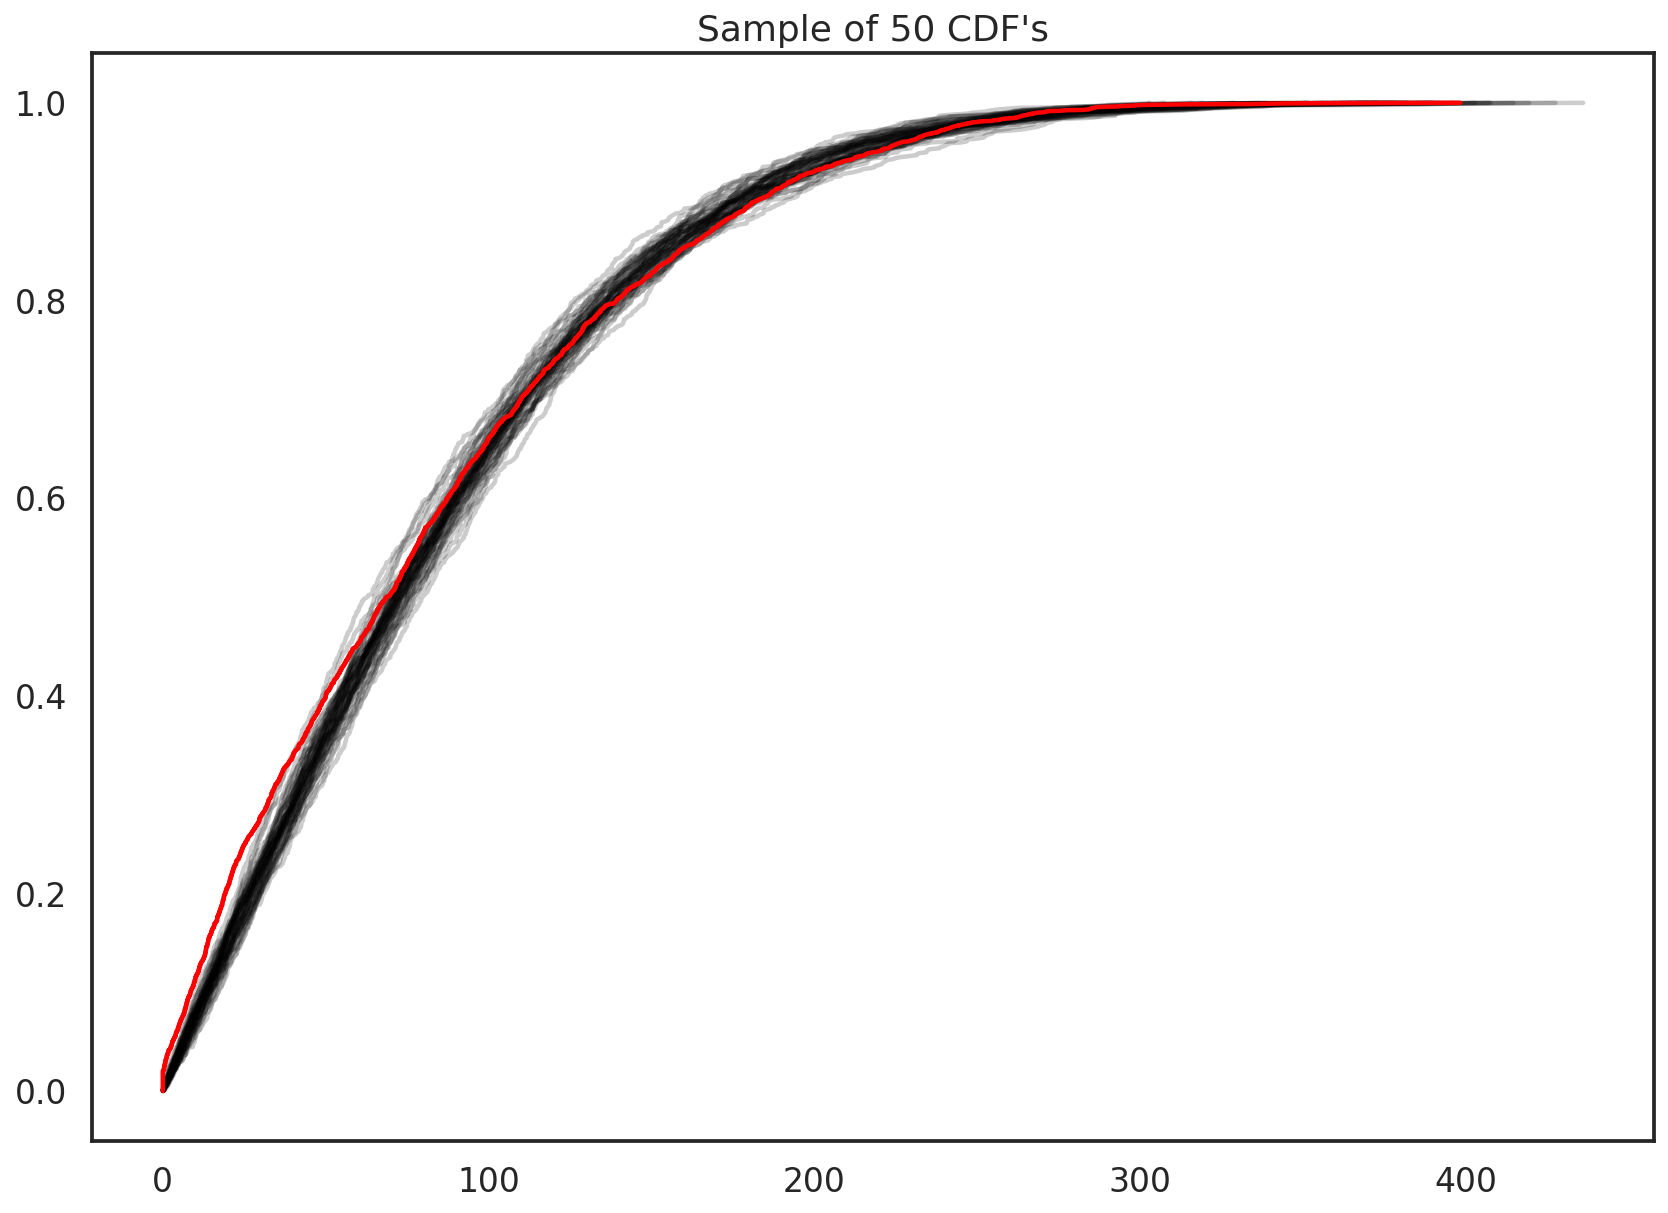

In [110]:
fig, ax = plt.subplots(figsize=(14,10))
for _sigma in np.random.choice(tr.sigma, size=50):
    mod_t = pymc3.distributions.HalfNormal.dist(sigma=_sigma)
    temp_samples = mod_t.random(size=1000)
    x_t, y_t = ecdf(temp_samples)   
    plt.plot(x_t, y_t, color='black', alpha=0.2)    
plt.plot(x_obs, y_obs, color='red')
plt.title("Sample of 50 CDF's")

Inferred sigma: 106.9450993891679


Text(0, 0.5, 'cumulative probability')

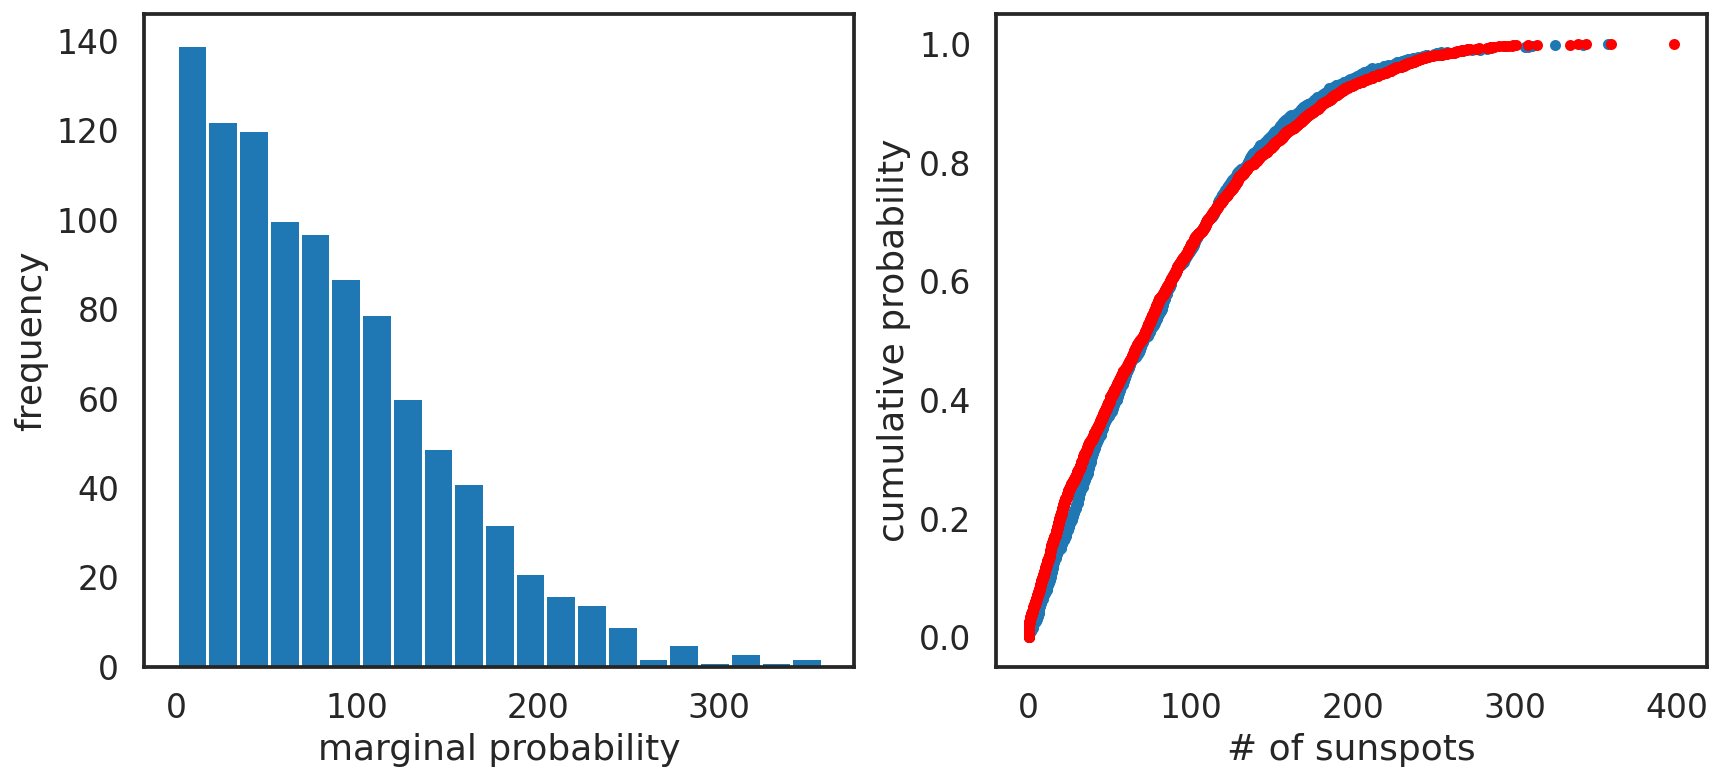

In [95]:
sunspot_model = sc.stats.halfnorm
tau, sigma = sunspot_model.fit(sunspots)

print("Inferred sigma:", sigma)

x_sc2 = sunspot_model.rvs(loc=0, scale=sigma, size=1000)
x_mod, y_mod = ecdf(x_sc2)

fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].hist(x_sc2, bins=21); 
ax[1].plot(x_mod, y_mod, marker='.', linestyle='none')
ax[1].plot(x_obs, y_obs, marker='.', linestyle='none', color='red')

ax[0].set_xlabel('marginal probability')
ax[0].set_ylabel('frequency')
ax[1].set_xlabel('# of sunspots')
ax[1].set_ylabel('cumulative probability')

# Simple examples

## GLM
From the deterministic 
$$Y \approx \mathbf{w} X + b$$
we go to probabilistic by for instance assuming that the values are distributed
normally around the mean, so
$$Y \approx \mathcal{N}(\mu, \sigma^2)$$
where 
$$\mu = w_1 X_1 + w_2 X^2_2 + b$$ 
and $\sigma^2$ represents the observation error (which is assumed to be independent of Y).

For an example we first generate some data.

In [214]:
w = [0.1, 0.8]
b = 2
sigma = 7

X1 = np.arange(200,0,-1)
X2 = np.arange(0,10,0.05)
Y = b + w[0]*X1 + w[1]*X2**2 + np.random.randn(200)*sigma

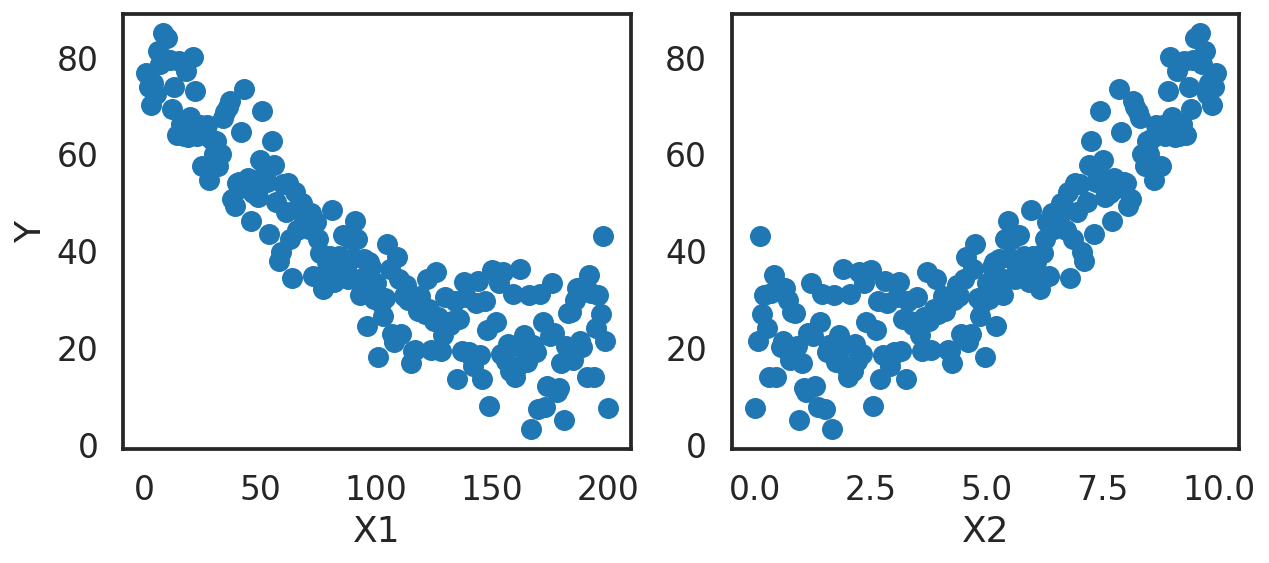

In [215]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

OK, so we have our observables, which are neatly linear :D.

In [217]:
# Our model
with pymc3.Model() as basic_model:
    # Priors for unknown model parameters
    b = pymc3.Normal('b', mu=0, sigma=10)
    w = pymc3.Normal('w', mu=0, sigma=10, shape=2)
    sigma = pymc3.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    mu = b + w[0]*X1 + w[1]*X2**2
    # Likelihood (sampling distribution) of observations
    Y_obs = pymc3.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

### MAP

First we find the Maximum A Posteriori likehood. This is the mode of the posterior distribution, for which
numerical optimizers like [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) and other non-linear optimisation techniques exist. This is relatively fast, but it gives a **point estimate**.

In [218]:
# Now we can find the posteriors for b, w, sigma
map_estimate = pymc3.find_MAP(model=basic_model)
print(map_estimate)

logp = -714.3, ||grad|| = 17.84: 100%|██████████| 25/25 [00:00<00:00, 2134.85it/s]      

{'b': array(0.01130336), 'w': array([0.11748109, 0.82693265]), 'sigma_log__': array(1.88576169), 'sigma': array(6.59137314)}


Text(0.5, 0.98, 'MAP estimate')

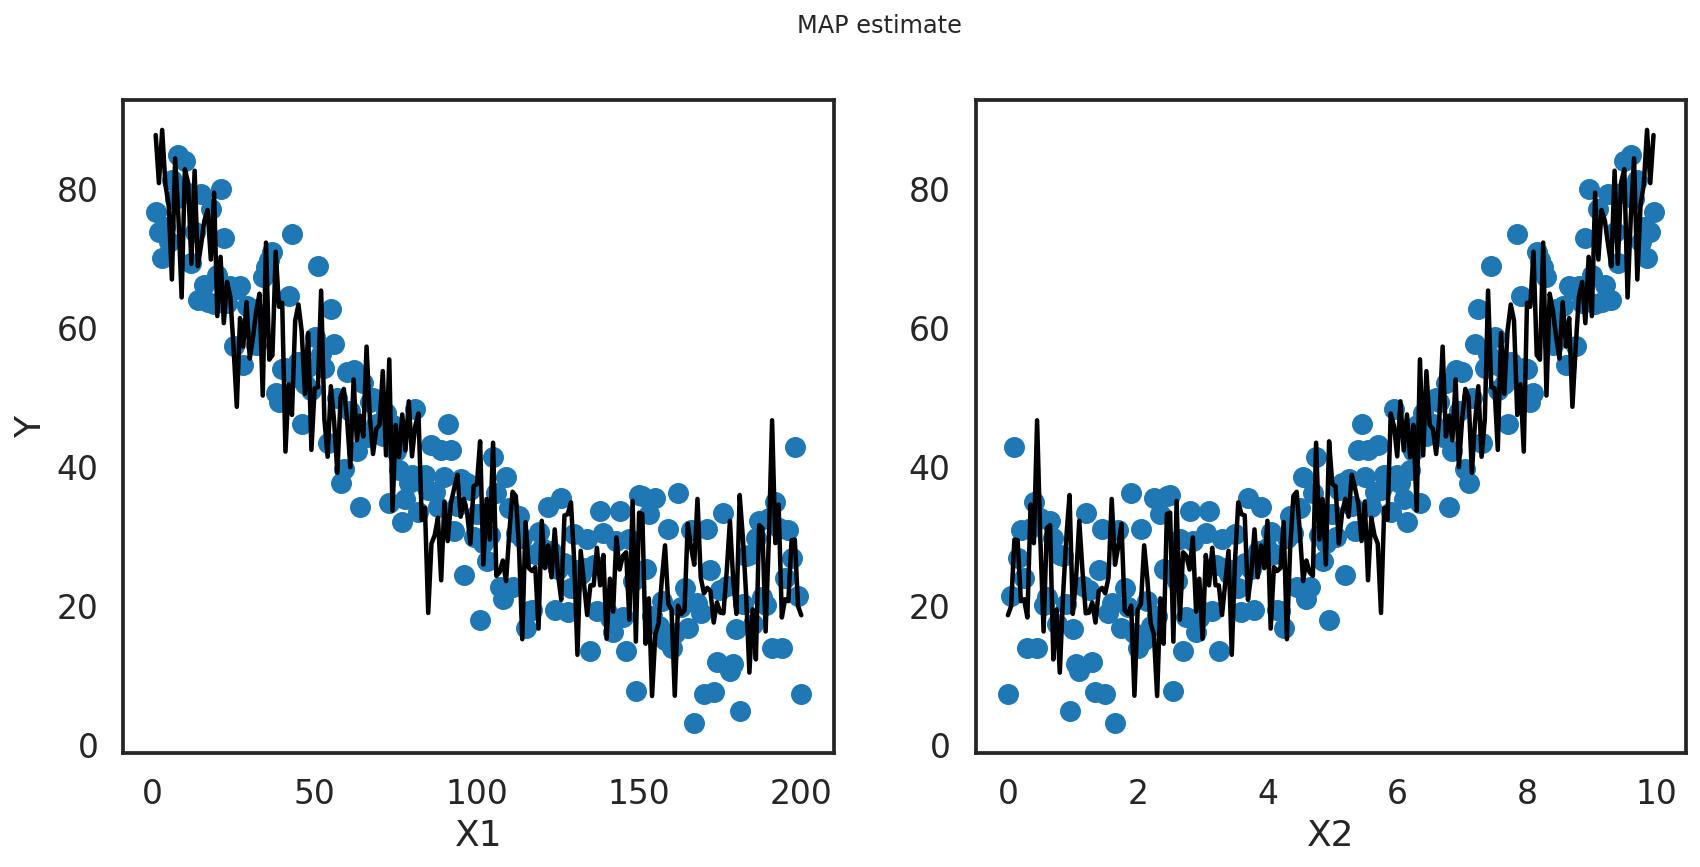

In [221]:
Yest_map = map_estimate['b'] + map_estimate['w'][0]*X1 + map_estimate['w'][1]*X2**2 \
                + np.random.randn(200)*map_estimate['sigma']

fig, ax = plt.subplots(1, 2, sharex=False, figsize=(14,6))
ax[0].scatter(X1, Y)
ax[0].plot(X1, Yest_map, color='black')

ax[1].scatter(X2, Y)
ax[1].plot(X2, Yest_map, color='black')

ax[0].set_ylabel('Y'); ax[0].set_xlabel('X1'); ax[1].set_xlabel('X2');
fig.suptitle("MAP estimate")

## Sampling

In [222]:
with basic_model:
    tr = pymc3.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, b]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 735.86draws/s]
The acceptance probability does not match the target. It is 0.8903220204824077, but should be close to 0.8. Try to increase the number of tuning steps.


Note: the sampler uses 4 **chains**, this refers to Markov chains.

For more information on sampling I can recommend [**this**](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/) great blog post.

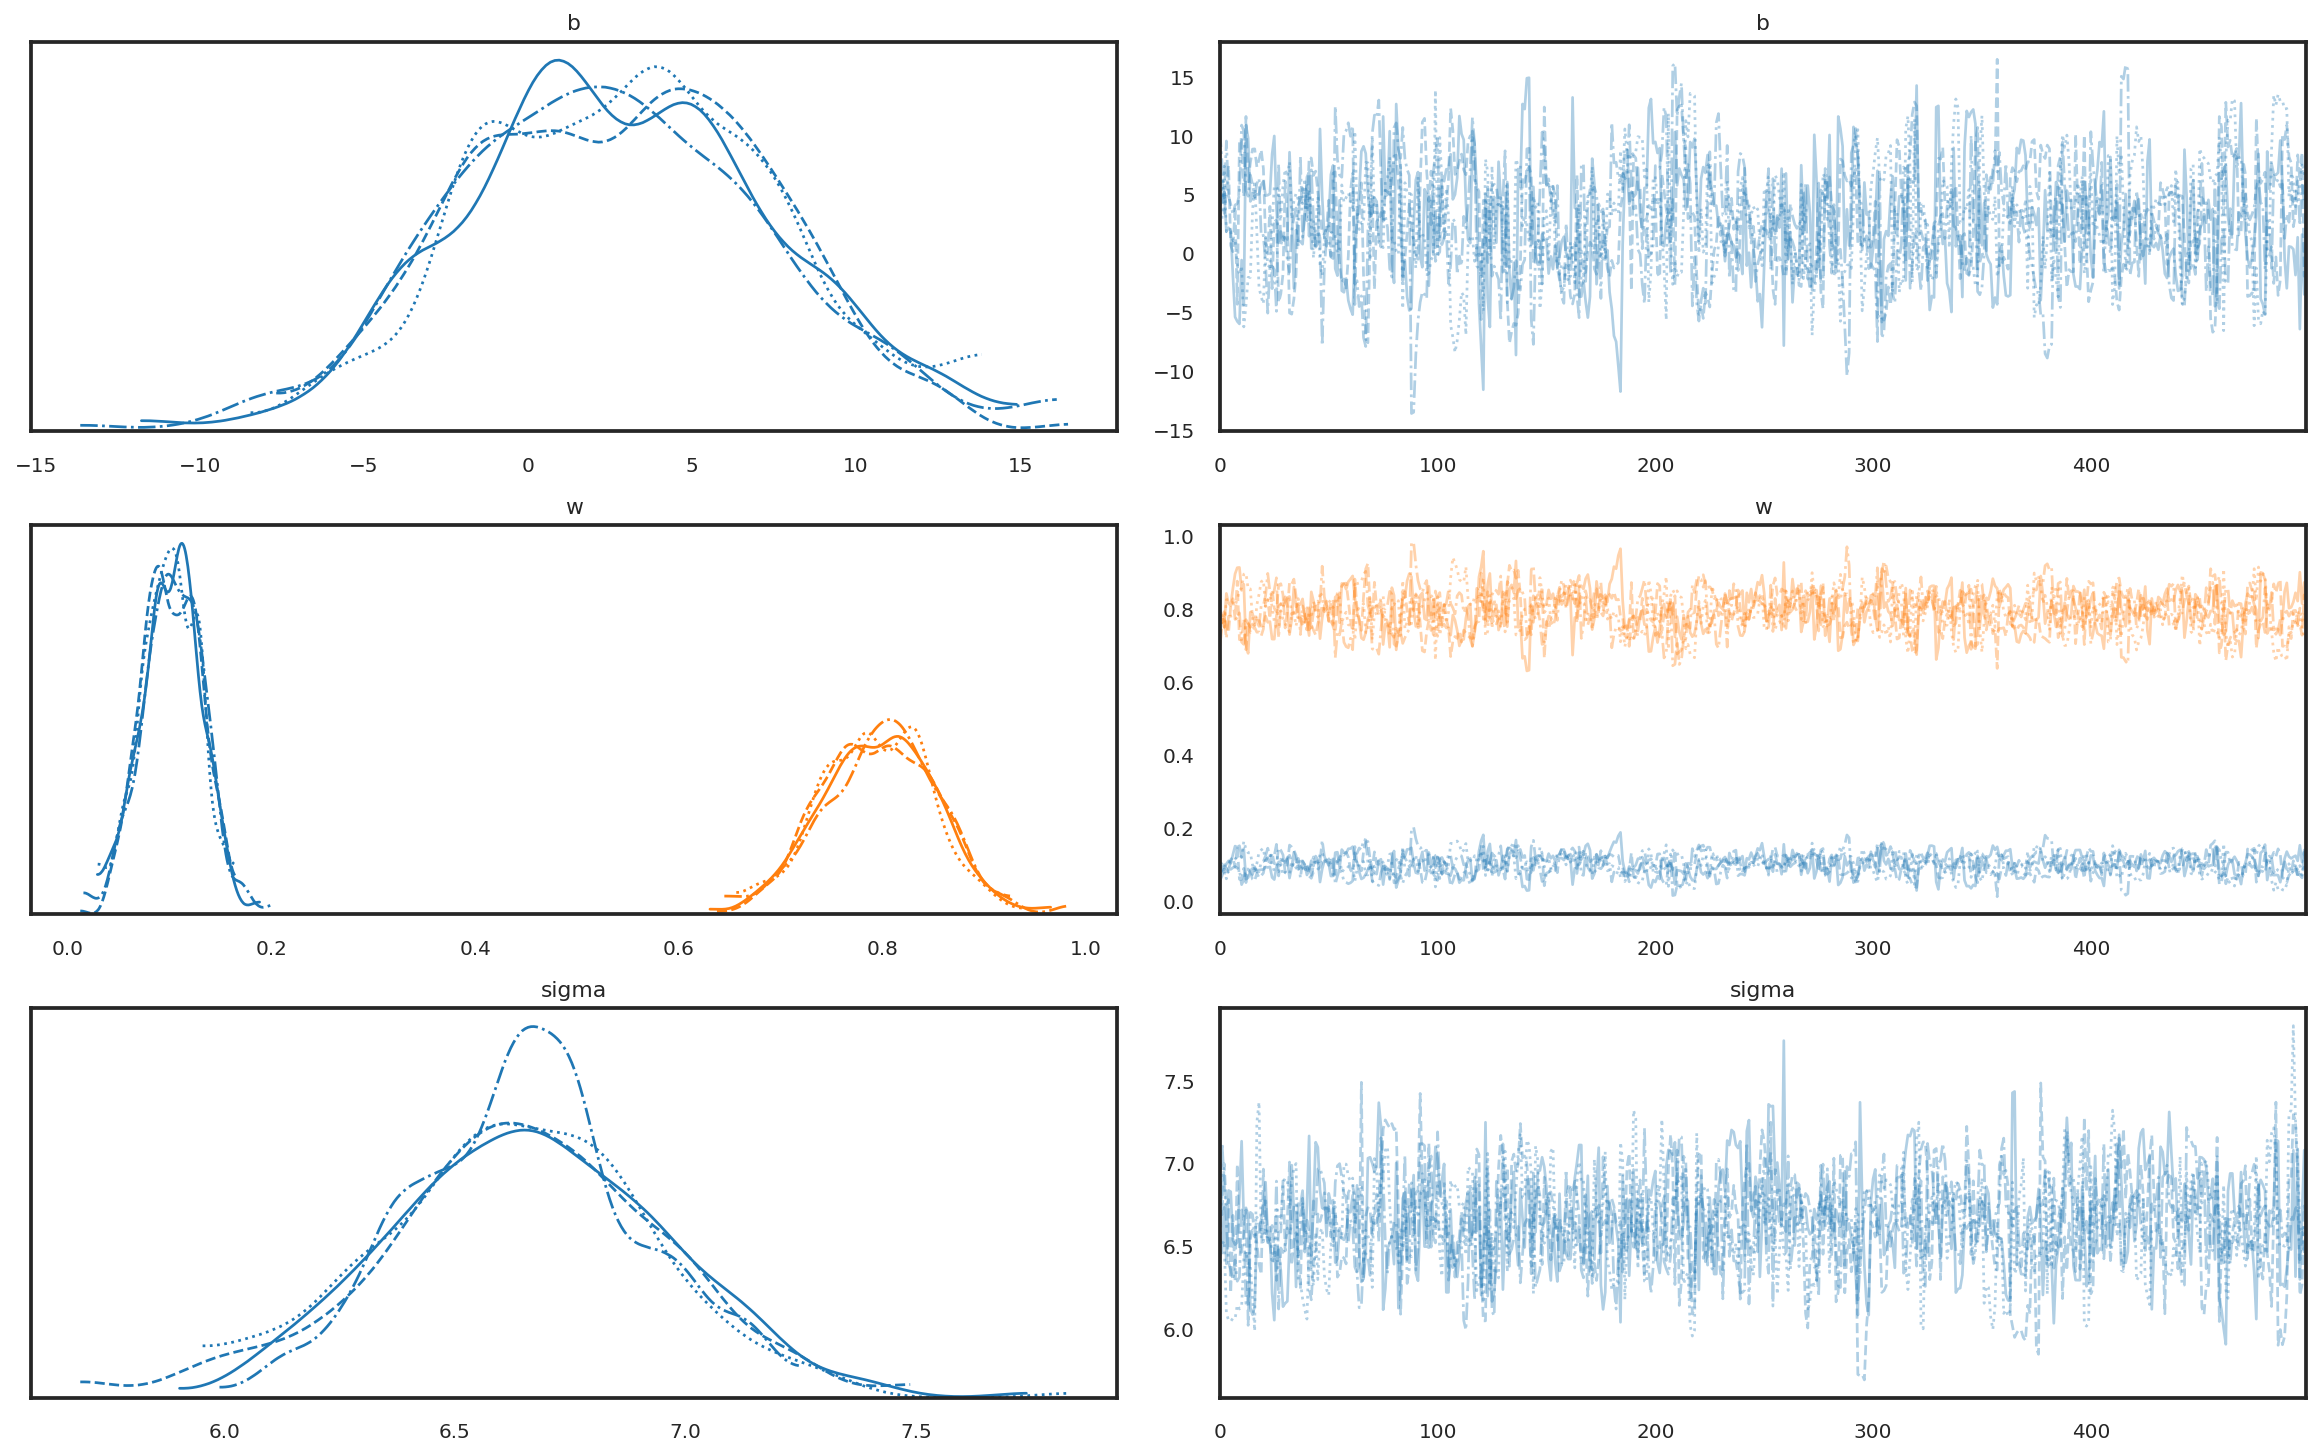

In [223]:
pymc3.traceplot(tr, figsize=(16,10));

In [224]:
pymc3.summary(tr).round(10)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b      2.696  4.621  -5.808   11.250      0.197    0.140     548.0   548.0   
w[0]   0.101  0.028   0.050    0.154      0.001    0.001     557.0   557.0   
w[1]   0.795  0.055   0.688    0.891      0.002    0.002     565.0   565.0   
sigma  6.644  0.284   6.112    7.187      0.011    0.008     640.0   640.0   

       ess_bulk  ess_tail  r_hat  
b         549.0     761.0   1.01  
w[0]      560.0     767.0   1.01  
w[1]      566.0     839.0   1.01  
sigma     644.0     521.0   1.01

Text(0.5, 0.98, 'MAP estimate')

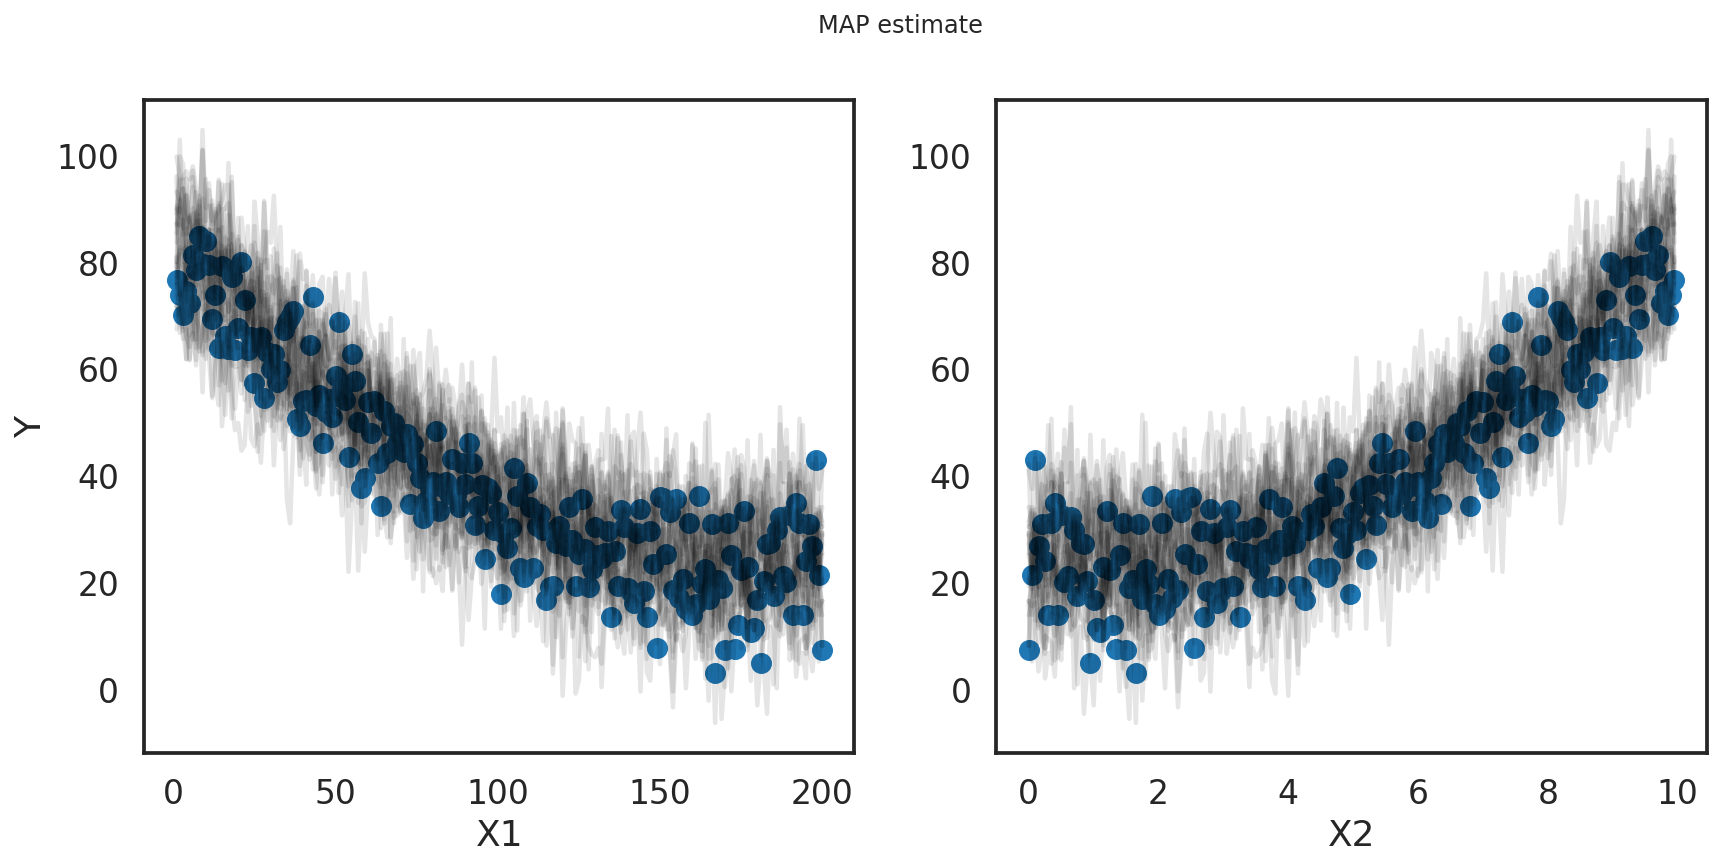

In [229]:
fig, ax = plt.subplots(1, 2, sharex=False, figsize=(14,6))
for _n in range(0,25):
    b = tr.b[np.random.randint(100)]
    w = tr.w[np.random.randint(100)]
    sigma = tr.sigma[np.random.randint(100)]
    
    Yest_nuts = b + w[0]*X1 + w[1]*X2**2 \
                + np.random.randn(200)*sigma
    
    ax[0].plot(X1, Yest_nuts, color='black', alpha=0.1)
    ax[1].plot(X2, Yest_nuts, color='black', alpha=0.1)

ax[0].scatter(X1, Y)
ax[1].scatter(X2, Y)
ax[0].set_ylabel('Y'); ax[0].set_xlabel('X1'); ax[1].set_xlabel('X2');
fig.suptitle("MAP estimate")

### Boston house prices

OK, so how about your everyday model inference? 

In [278]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler

In [546]:
transformer = QuantileTransformer(output_distribution='normal') #  None # QuantileTransformer(output_distribution='normal') # MinMaxScaler() # StandardScaler()

**Features**:
* CRIM: This is the per capita crime rate by town
* ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
* INDUS: This is the proportion of non-retail business acres per town.
* CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
* NOX: This is the nitric oxides concentration (parts per 10 million)
* RM: This is the average number of rooms per dwelling
* AGE: This is the proportion of owner-occupied units built prior to 1940
* DIS: This is the weighted distances to five Boston employment centers
* RAD: This is the index of accessibility to radial highways
* TAX: This is the full-value property-tax rate per $10,000$
* PTRATIO: This is the pupil-teacher ratio by town
* B: This is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people of African American descent by town
* LSTAT: This is the percentage lower status of the population

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (506). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (506). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (506). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


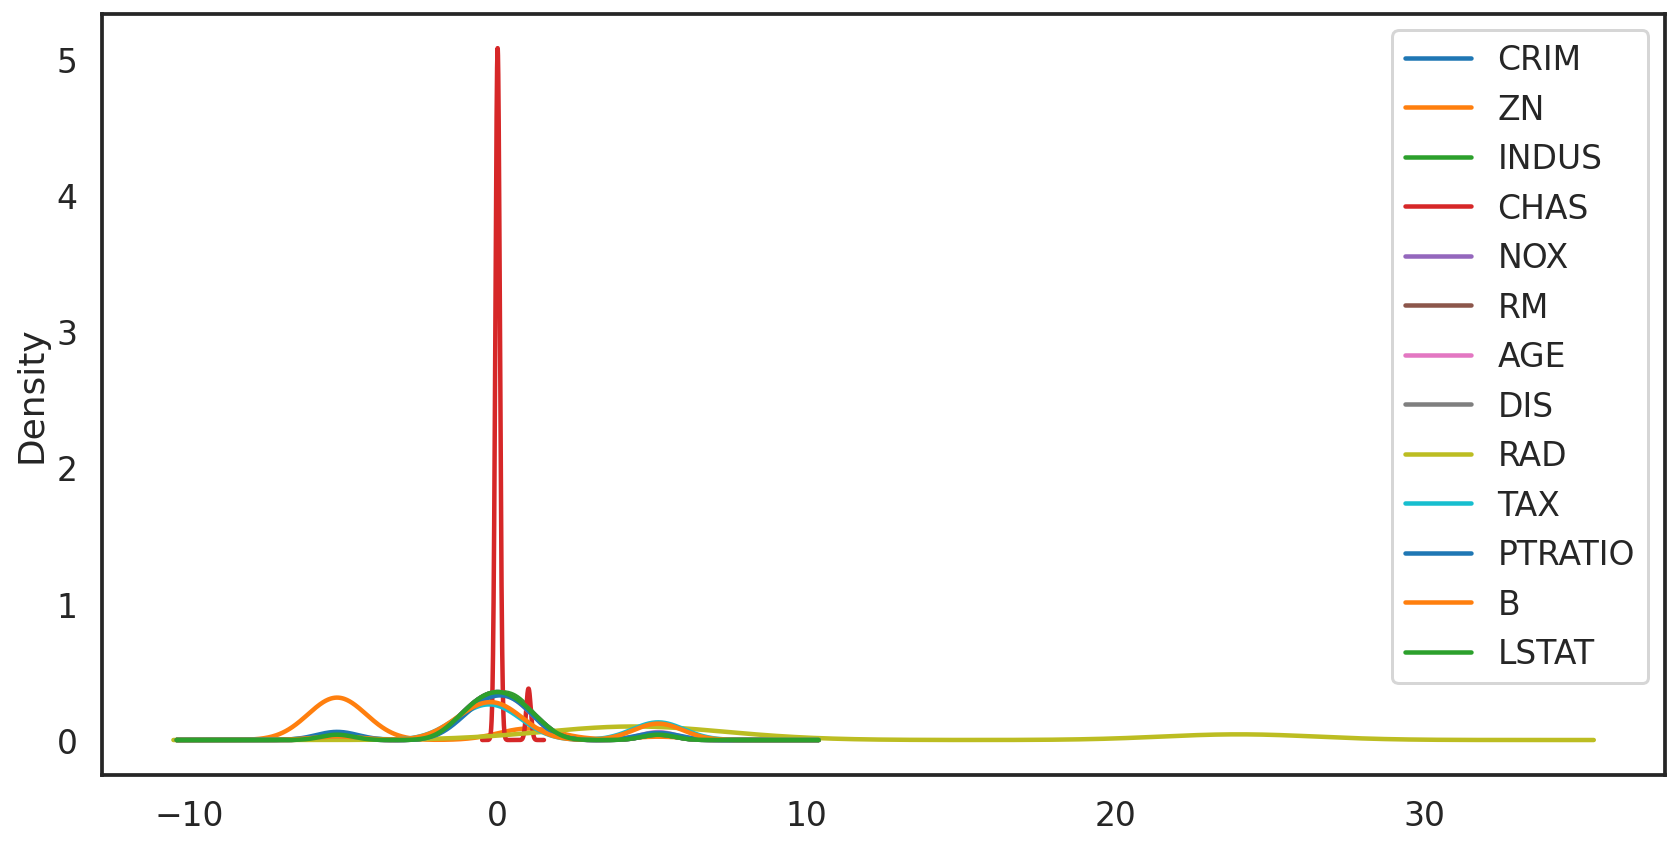

In [547]:
boston_data = load_boston()
X = boston_data['data']
Y = np.log10(boston_data['target'])
X[:, :3] = featurewise_outlier_replacer(X[:, :3], q=(0.05, 0.95))
X[:, 4:8] = featurewise_outlier_replacer(X[:, 4:8], q=(0.05, 0.95))
X[:, 9:13] = featurewise_outlier_replacer(X[:, 9:13], q=(0.05, 0.95))

X[:, :3] = X if transformer is None else transformer.fit_transform(X[:, :3]) 
X[:, 4:8] = X if transformer is None else transformer.fit_transform(X[:, 4:8]) 
X[:, 9:13] = X if transformer is None else transformer.fit_transform(X[:, 9:13]) 

features = boston_data['feature_names']
boston_df = pd.DataFrame(data=X, columns=features)

plt.figure(figsize=(14,7))
for _col in boston_df.columns:
    boston_df[_col].plot.kde(label=_col)
plt.legend()

(array([  3.,   8.,  13.,  23.,  63., 100., 172.,  52.,  40.,  32.]),
 array([0.69897, 0.79897, 0.89897, 0.99897, 1.09897, 1.19897, 1.29897,
        1.39897, 1.49897, 1.59897, 1.69897]),
 <a list of 10 Patch objects>)

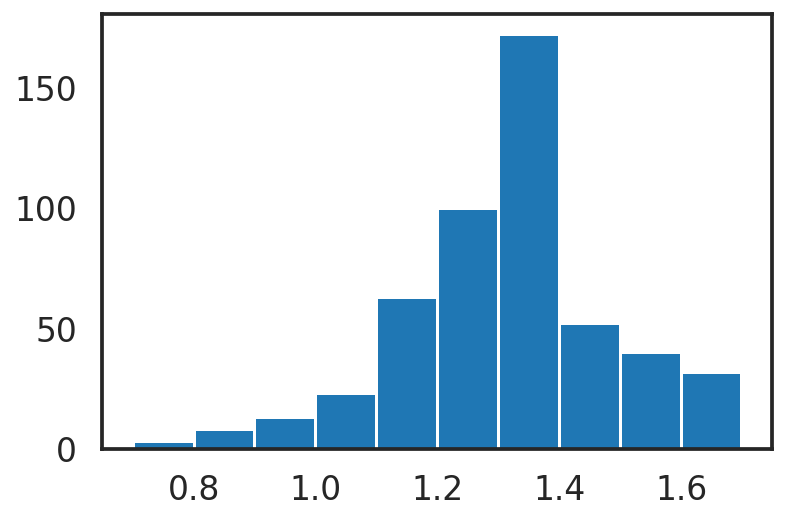

In [548]:
plt.hist(Y)

normally: 
$$Y \approx \sum w_i X_i + b $$

or more generally

$$Y \approx \sum w_i \, \mathcal{f}\left(X_i\right) + b $$

and even more generally 

$$Y \approx \mathcal{f}\left(X_1,\dots, X_D\right) $$

Now, we are lazy and we do not want to manually determine the appropriate distribution for each feature, 
so we assume normal distributions.. Again we have

$$
Y\approx  \mathcal{N}\left(\mu, \sigma^2\right)
$$

with 
$$
\mu = \sum^D_i w_i X_i + b
$$

where, for each $w$ we can in principle choose a specific distribution, but..we are lazy so. 

In [549]:
pRAD = (boston_df.groupby('RAD').size()/boston_df.shape[0]).values

with pymc3.Model() as boston_model:
    # Priors
    w1 = pymc3.Normal('w1', mu=0.1, sd=0.1, shape=3)
    wCHAS = pymc3.Binomial('CHAS', n=506, p=np.mean(boston_df.CHAS.values))
    w2 = pymc3.Normal('w2', mu=0.1, sd=0.1, shape=4)
    wRAD = pymc3.Categorical('RAD', p=pRAD)
    w3 = pymc3.Normal('w3', mu=0.1, sd=0.1, shape=4)
    
    b = pymc3.Normal('b', mu=np.mean(Y), sd=0.1)
    sigma = pymc3.HalfCauchy('sigma', beta=0.05)
    
    # Likelihood
    price = b + pymc3.math.dot(X[:,:3], w1) + wCHAS*X[:, 3] \
                + pymc3.math.dot(X[:,4:8], w2) + wRAD*X[:, 8] \
                 + pymc3.math.dot(X[:, 9:13], w3)
    Y_est = pymc3.Normal('Y_est', mu=price, sd=sigma, observed=Y)

In [550]:
# MAP
map_estimate_boston = pymc3.find_MAP(model=boston_model)

INFO (theano.gof.compilelock): Refreshing lock /home/koekiemonster/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -3,168.6, ||grad|| = 571.27: 100%|██████████| 31/31 [00:00<00:00, 1714.47it/s]        


In [551]:
map_estimate_boston

{'w1': array([0.06250763, 0.2559678 , 0.08685219]),
 'CHAS': array(35),
 'w2': array([0.06726577, 0.11261087, 0.06866382, 0.12697608]),
 'RAD': array(8),
 'w3': array([-0.01446351,  0.09097361,  0.0923762 ,  0.08077081]),
 'b': array(1.2817613),
 'sigma_log__': array(4.64973774),
 'sigma': array(104.55756118)}

In [552]:
warray = np.hstack([map_estimate_boston['w1'],
                    map_estimate_boston['CHAS'],
                    map_estimate_boston['w2'],
                    map_estimate_boston['RAD'],
                    map_estimate_boston['w3']])
Y_est = estimator_fun(X, warray, map_estimate_boston['b'], map_estimate_boston['sigma'])

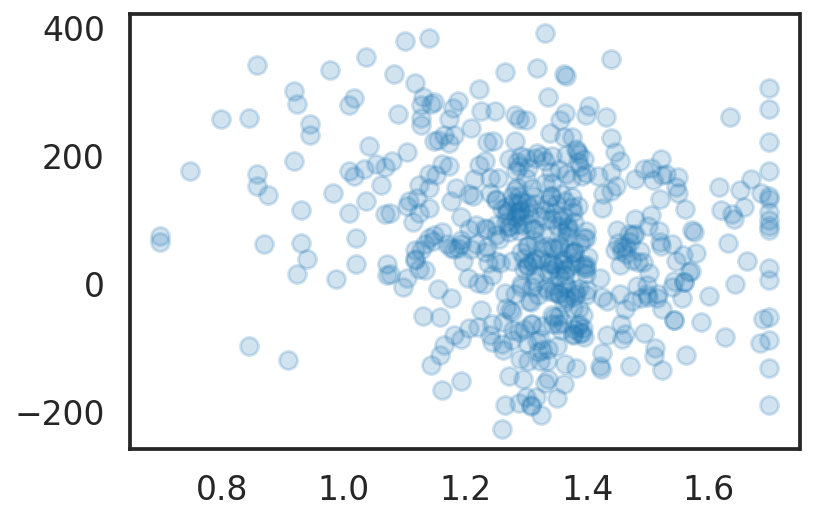

In [553]:
plt.scatter(Y, Y_est, alpha=0.2)

In [554]:
# Sampler
with boston_model:
    tr = pymc3.sample(1000, tune=1000, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigma, b, w3, w2, w1]
>Metropolis: [CHAS]
>CategoricalGibbsMetropolis: [RAD]
Sampling chain 1, 999 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 519.27it/s]
There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2728563065500001, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


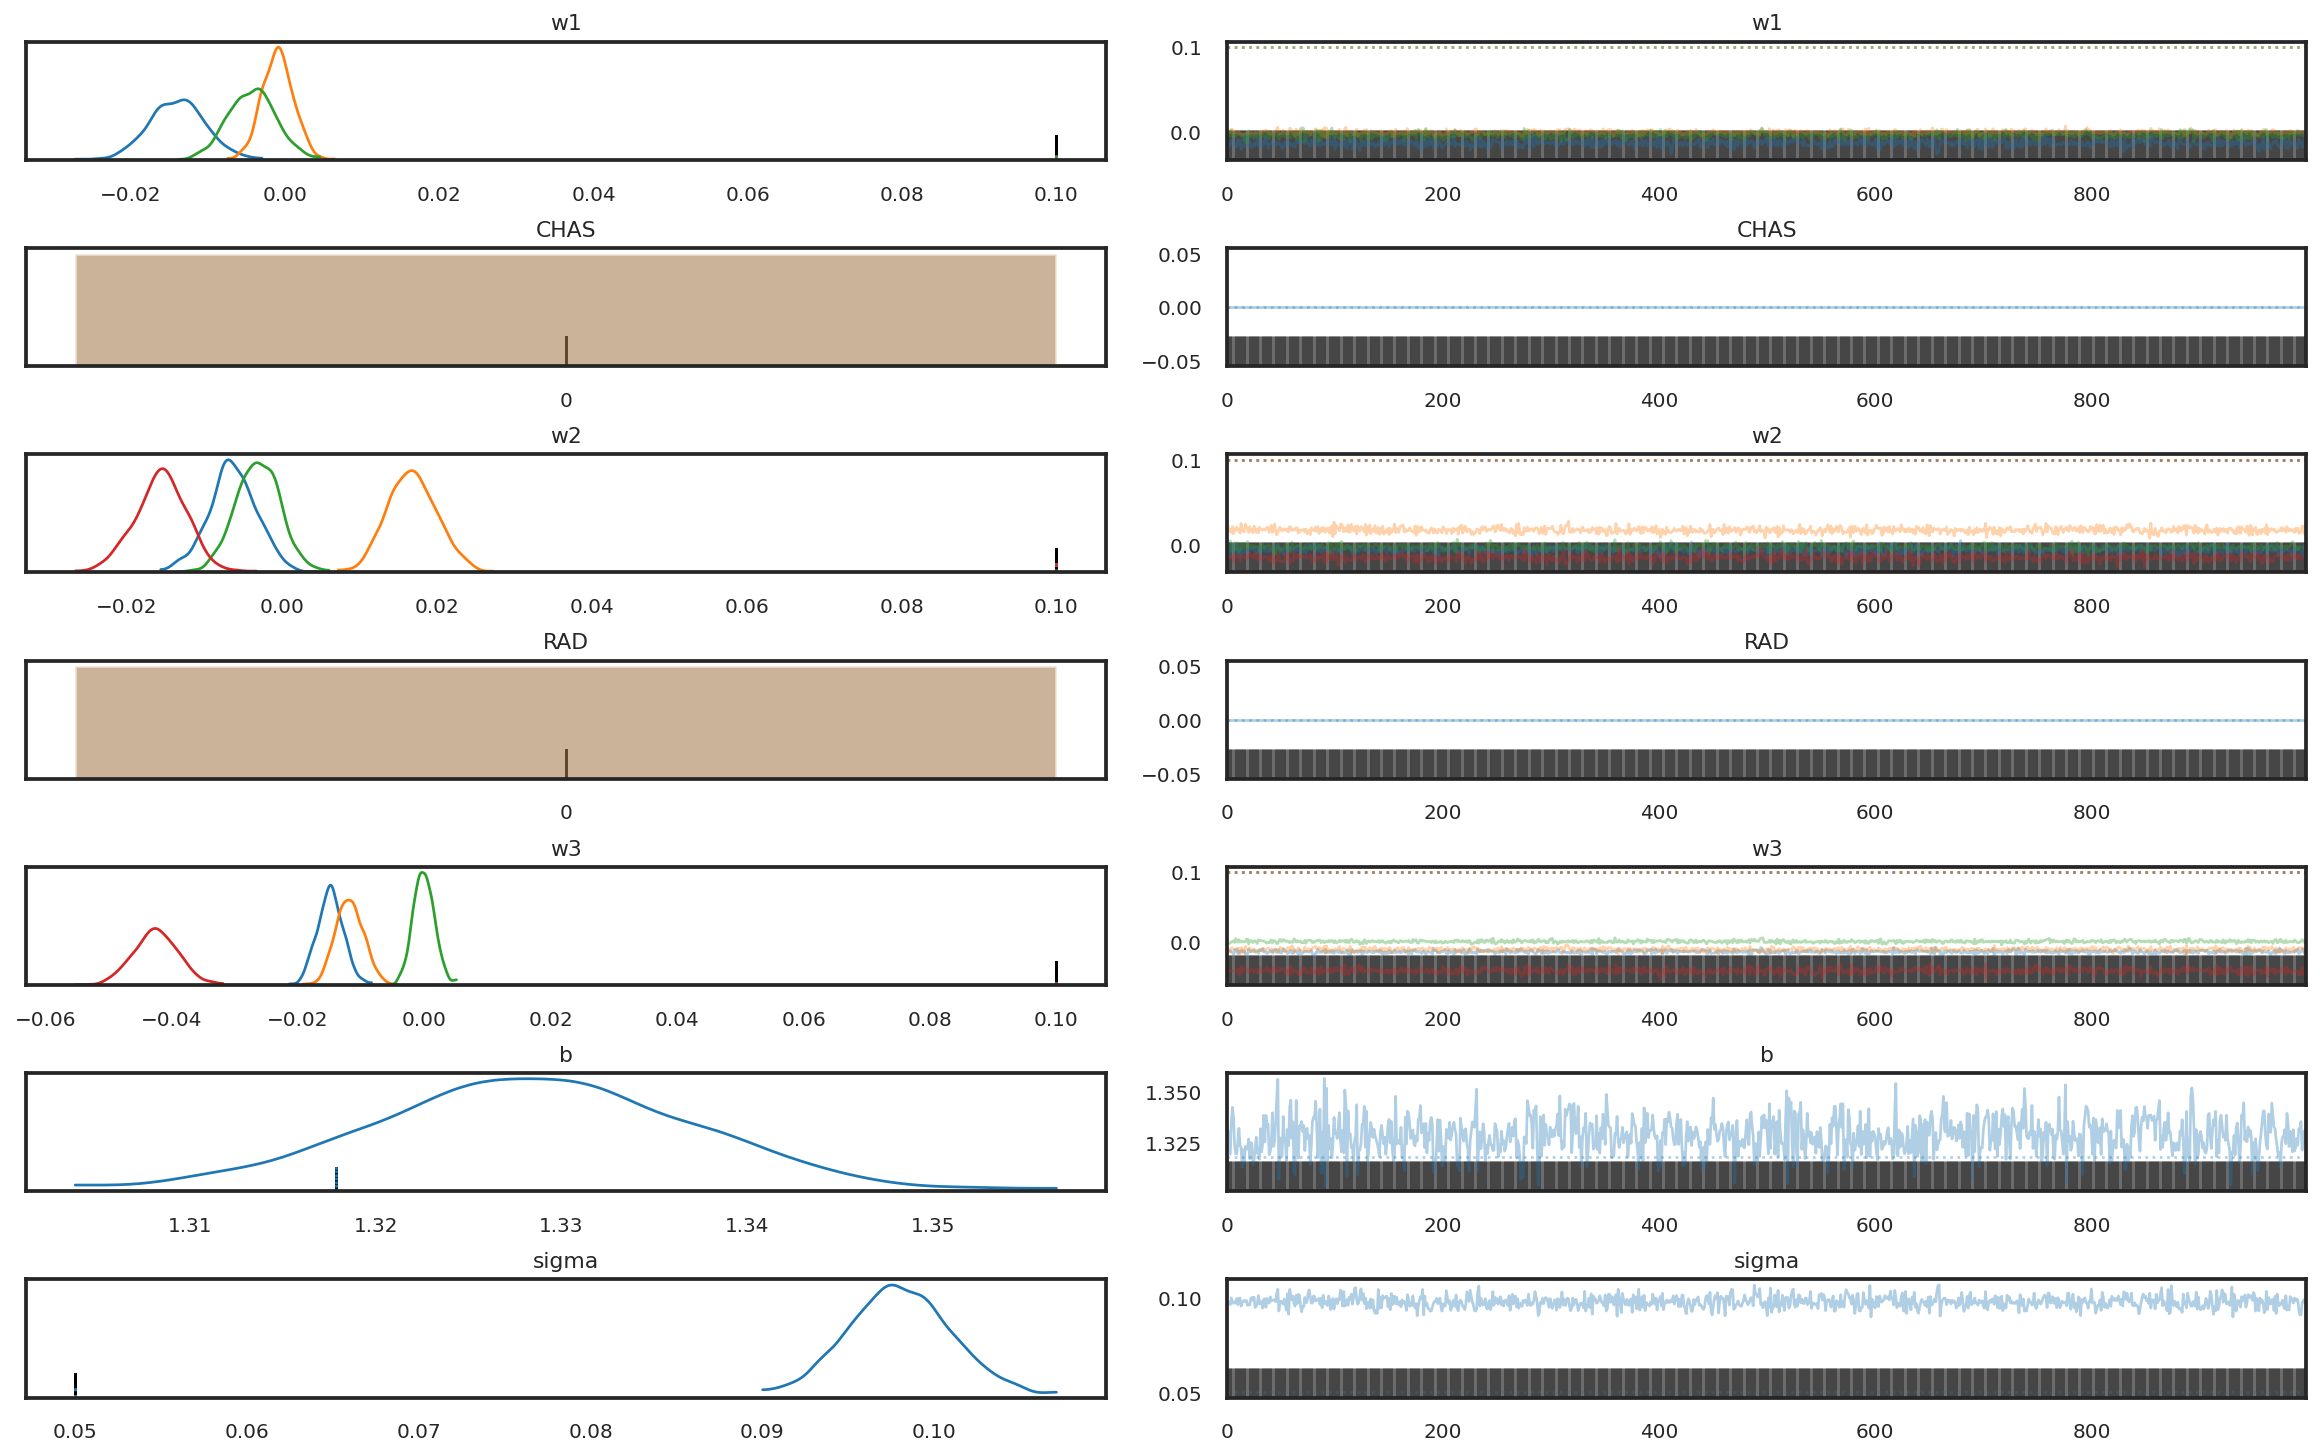

In [555]:
pymc3.traceplot(tr, figsize=(16,10));

This will not work because most of the features cannot be adequately described by any of the prior distributions.

## Logistic Regression

In [ ]:
...

### Breast cancer

In [ ]:
...

## Poisson regression

In [ ]:
...

## Applied to differential equations

### SIR modelling

## Hierarchical Bayesian modelling

# Questions

* Assumption free ?
* Multi-modality?
* Computational expense?